# additions needed for this to work:
We need to go into feature engineering and start adding a index for each trial on asymmetry per trial at the maxes for each of those and specific moments like on the landing, jump and release

Do the asymmetry for each of the important connections:     
additional_asymmetry_joints = ['shoulder', 'hip', 'ankle', 'wrist', 'elbow', 'knee', 'foot', '1sttoe', '5thtoe', '1stfinger', '5thfinger']
for example:
    # Define the joints for which we want asymmetry calculations.
    additional_asymmetry_joints = ['shoulder', 'hip', 'ankle', 'wrist', 'elbow', 'knee', 'foot', '1sttoe', '5thtoe', '1stfinger', '5thfinger']
    for joint in additional_asymmetry_joints:
        left_col = f"L_{joint.upper()}_energy"
        right_col = f"R_{joint.upper()}_energy"
        if left_col in data.columns and right_col in data.columns:
            col_name = f"{joint}_asymmetry"
            data[col_name] = np.abs(data[left_col] - data[right_col])
            new_cols.append(col_name)
            logging.info(f"Created asymmetry feature: {col_name}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_asymmetry.")
            

Goal:

Time Series Analysis:
Regression: Trial Exhaustion Rate

Classification: Injury Risk Predictions for each joint


## Updated Goals and Pipeline Breakdown

### **Overall Objectives**

1. **Data Loading and Preprocessing:**
   - **Data Sources & Merging:**  
     Load a CSV dataset that contains trial‐level measurements (e.g., joint energy, joint power, etc.) and additional participant information. Use unique identifiers such as `trial_id` and `player_participant_id` to ensure proper merging and ordering.
   - **Data Cleaning:**  
     Identify and impute or drop missing values as needed. Logging and debugging functions are used throughout to verify data integrity.

2. **Feature Engineering:**
   - **Base Features (for both pipelines):**
     - **Joint Energy and Power Metrics:**  
       Derive aggregated features such as `joint_energy` (by summing across joint-specific energy columns) and `joint_power` (by summing various joint power measures, e.g., `L_ANKLE_avg_power`, `R_ANKLE_avg_power`, etc.).  
     - **Simulated Heart Rate:**  
       Compute a simulated heart rate (`simulated_HR`) using a function of mean energy and joint energy, which serves as a proxy for physiological stress.
   - **Temporal Features and Rolling Statistics:**
     - **Lag Features:**  
       Create lag features like `exhaustion_lag1` by shifting metrics (e.g. using the previous trial’s exhaustion score).  
     - **Rolling Averages and Volatility:**  
       Compute rolling averages (e.g. `power_avg_5`) and rolling standard deviations (volatility features such as `joint_power_volatility`) to capture smooth trends and variability over a moving window of trials.
   - **Exhaustion Rate Calculation:**  
     Compute the trial exhaustion rate by calculating the change in exhaustion score (or its surrogate) divided by the change in trial number.
   - **Asymmetry Features:**  
     Compute differences between left and right joint metrics (e.g., `elbow_asymmetry` and `knee_asymmetry`) to capture potential imbalances.
   - **Fake Body Metrics (New Addition):**  
     Add realistic fake human statistics such as:
     - **sleep_quality** (score from 50 to 100),
     - **sleep_duration** (hours of sleep, between 5 and 9),
     - **resting_HR** (resting heart rate in bpm, between 50 and 80),
     - **HR_variability** (heart rate variability in ms, between 20 and 100),
     - **stress_index** (stress level from 1 to 10).  
     These features simulate wearable or self-reported data that might affect both fatigue and injury risk.

3. **Workout Simulation (New Addition):**
   - **Simulate Two Workouts:**  
     Instead of a single workout (125 trials), we simulate two workouts:
     - The first workout is kept as-is.
     - The second workout is a duplicate of the first, but with realistic “deterioration” in the fake body metrics. For example:
       - **sleep_quality** decreases gradually by up to 10 points,
       - **sleep_duration** drops slightly,
       - **resting_HR** increases by up to 5 bpm,
       - **HR_variability** decreases by up to 10 ms,
       - **stress_index** increases by up to 2 points.
   - **Workout Identification and Trial Counter:**  
     Add a `workout_id` column (1 for the original workout, 2 for the simulated workout) and a `trial_in_workout` column (numbering trials from 1 to 125 within each workout). Then, both workouts are concatenated into one DataFrame so that the downstream pipeline can process them together.

4. **Pipeline 1 – Regression for Trial Exhaustion Rate:**
   - **Data Preparation:**
     - Use the merged dataset (now containing two workouts) and sort by trial (or shot) order.
     - Clean the data and remove rows with missing values.
   - **Feature Selection and Transformation:**
     - **Input Features:**  
       Include aggregated joint energy, joint power, simulated heart rate, the rolling average of joint power (e.g. `power_avg_5`), lag features (e.g. `exhaustion_lag1`), and the fake body metrics.
     - **Target Variable:**  
       Compute the trial exhaustion rate (using the change in exhaustion score per trial) as the target variable.
   - **Model Training:**
     - **Baseline Model:**  
       Start with a linear regression model to set a baseline.
     - **Advanced Models:**  
       If needed, progress to ensemble methods (Random Forests, Gradient Boosting) or LSTM networks to capture temporal dependencies.
   - **Evaluation:**
     - Use metrics such as MAE, RMSE, or R².
     - Visualize the predictions versus actual values over time.

5. **Pipeline 2 – Classification for Joint Injury Risk Prediction:**
   - **Data Preparation:**
     - Use the same sorted and cleaned dataset.
     - Ensure joint-specific columns are available (e.g. `L_ANKLE_avg_power`, `R_ELBOW_energy_mean`, etc.).
   - **Feature Engineering for Injury Risk:**
     - **Joint-Specific Metrics:**  
       Retain joint-specific energy and power metrics.
     - **Asymmetry and Rolling Features:**  
       Calculate asymmetry metrics (e.g. `elbow_asymmetry`, `knee_asymmetry`) and rolling aggregates that capture cumulative load.
     - **Derive Injury Risk Labels:**  
       For each joint, compute a risk signal (e.g. by thresholding a rolling sum of energy or exhaustion scores). For instance, if a rolling sum exceeds the 75th percentile, label that trial as high risk (1) for that joint; otherwise, label as low risk (0).
   - **Model Training:**
     - **Input Features:**  
       Use the joint-specific metrics, asymmetry features, and rolling statistics.
     - **Classifier:**  
       Start with baseline classifiers (e.g. Logistic Regression or Decision Trees) and then advance to Random Forests, SVM, or neural network classifiers (LSTM-based) as needed.
   - **Evaluation:**
     - Evaluate with accuracy, precision, recall, F1-score, ROC-AUC.
     - Use confusion matrices and SHAP feature importance analysis to interpret which features drive injury risk predictions.

6. **Integration and Modularization:**
   - **Separate Functions:**  
     Each step (data loading, feature engineering, simulation, model training, evaluation) is encapsulated in its own function. For example, functions in our code such as `load_final_ml_dataset`, `prepare_joint_features`, `feature_engineering`, `add_fake_body_metrics`, and the newly added `simulate_workouts` keep our pipeline modular.
   - **Debugging and Logging:**  
     We use logging at each step to confirm the transformations and to trace the computation. Visualizations (histograms, correlation matrices, temporal trend plots) are generated to validate the quality of our features.
   - **Iterative Refinement:**  
     With the initial results, we can revisit the feature engineering stage (e.g., try different window sizes or lag periods) and adjust the model hyperparameters for optimal performance.

---

## In Summary

### **For Regression (Predicting Trial Exhaustion Rate):**

1. **Data Loading and Preparation:**  
   - Load and merge the CSV (and other files) using trial and participant IDs.
   - Sort by trial order and clean missing values.

2. **Feature Engineering:**  
   - Compute aggregated joint energy and power metrics.
   - Compute simulated heart rate and use exhaustion-related scores.
   - Generate lag features (e.g. `exhaustion_lag1`) and rolling features (e.g. `power_avg_5`).
   - Compute the exhaustion rate (target) from differences in exhaustion scores.
   - Include additional fake body metrics (sleep, HR, stress).

3. **Modeling:**  
   - Split the dataset (preserving temporal order).
   - Train a regression model (start with linear regression, then explore Random Forests/LSTM).
   - Evaluate with MAE, RMSE, R², and visualize the predictions.

### **For Classification (Predicting Injury Risk for Each Joint):**

1. **Data Preparation:**  
   - Use the same cleaned dataset.
   - Ensure that joint-specific energy/power columns and asymmetry metrics are available.

2. **Feature Engineering:**  
   - Keep joint-specific metrics separate to capture local joint dynamics.
   - Compute rolling aggregates (e.g., rolling sum of exhaustion) and threshold them (e.g., using the 75th percentile) to produce binary injury risk labels.
   - Label the dataset per joint (e.g., `L_ANKLE_injury_risk`).

3. **Modeling:**  
   - Split the data (ensuring temporal order is preserved).
   - Train a classification model (start with logistic regression or decision trees, then advance to neural network classifiers if needed).
   - Evaluate using accuracy, precision, recall, F1-score, ROC-AUC.
   - Use SHAP or similar methods for feature importance analysis.

### **New Simulation of Two Workouts:**

- **Workout Simulation:**  
  After initial feature engineering and after adding fake body metrics, we simulate two workouts by:
  - Marking the original 125–trial data as workout 1.
  - Duplicating it as workout 2 and simulating gradual deterioration in fake body metrics (sleep, HR, stress, etc.) over the trials.
  - Adding a `workout_id` column and a `trial_in_workout` counter.
  - Concatenating the two workouts for downstream processing.

This detailed breakdown helps us understand exactly how each column is computed, transformed, and fed into our modeling pipelines for regression and classification. It also shows how we incorporate temporal dynamics, simulated fatigue, and realistic human statistics into our analysis.



Final Pipeline Overview
Regression Pipeline: Predicting Trial Exhaustion Rate

    Target Variable (y):
        Trial Exhaustion Rate:
        The change in exhaustion score per trial (i.e., the difference between consecutive exhaustion scores divided by the difference in trial number).

    Input Features (x Variables):
    These features are designed to capture both the physical output of the participant as well as simulated physiological states.

        Aggregated Joint Metrics:
            Joint Energy (joint_energy):
            The sum of energy measurements from various joints.
            Joint Power (joint_power):
            The sum of power measures from several joints (e.g., L_ANKLE_avg_power, R_ANKLE_avg_power, etc.).

        Simulated Physiological Measure:
            Simulated Heart Rate (simulated_HR):
            Computed as a function of the mean energy and aggregated joint energy. This serves as a proxy for physiological stress.

        Temporal and Rolling Features:
            Lag Features (e.g., exhaustion_lag1):
            The exhaustion score from the previous trial, capturing immediate past performance.
            Rolling Averages (e.g., power_avg_5):
            A moving average of joint power (over a window of 5 trials, for example) to capture smoothed trends.
            Volatility Measures (e.g., joint_power_volatility):
            The rolling standard deviation of joint power, capturing the variability across recent trials.

        Fake Body Metrics:
        These simulate real-world physiological or self-reported data:
            Sleep Quality (sleep_quality): A score ranging from 50 to 100.
            Sleep Duration (sleep_duration): Hours of sleep (between 5 and 9).
            Resting Heart Rate (resting_HR): Beats per minute (between 50 and 80).
            Heart Rate Variability (HR_variability): Variability in ms (between 20 and 100).
            Stress Index (stress_index): A score from 1 to 10 indicating stress level.

        Workout Simulation Markers:
            Workout ID (workout_id): Indicates whether the data is from the original workout (1) or the simulated deteriorated workout (2).
            Trial in Workout (trial_in_workout): The trial number within each workout (1–125).

    Prediction Goal:
    To forecast how quickly exhaustion increases (or decreases) based on the combined influence of joint outputs, temporal trends, and physiological states.

Classification Pipeline: Predicting Injury Risk for Each Joint

    Target Variable (y):
        Injury Risk Labels (Binary per Joint):
        For each joint (e.g., left ankle, right elbow), we generate a binary label:
            High Risk (1): When the cumulative stress or energy (e.g., a rolling sum of exhaustion or joint energy) exceeds a defined threshold (e.g., the 75th percentile).
            Low Risk (0): Otherwise.

    Input Features (x Variables):
    These features focus on capturing joint-specific load and potential imbalances, as well as temporal dynamics.

        Joint-Specific Metrics:
            Individual Joint Energy and Power:
            Measurements such as L_ANKLE_avg_power, R_ELBOW_energy_mean, etc., which allow the model to understand the load and output at each specific joint.

        Asymmetry Features:
            Examples:
                Elbow Asymmetry (elbow_asymmetry): The difference between left and right elbow metrics.
                Knee Asymmetry (knee_asymmetry): The difference between left and right knee metrics.
                These features help capture imbalances that might contribute to injury risk.

        Rolling Aggregates:
            Cumulative Load Metrics:
            For example, a rolling sum or average of joint energy or exhaustion scores that capture how stress accumulates over multiple trials.

        Fake Body Metrics:
            The same set of metrics as in the regression pipeline (sleep quality, sleep duration, resting_HR, HR_variability, stress_index) which provide additional context on the participant’s physiological state.

        Temporal Features:
            Lag Features:
            Such as the previous trial’s exhaustion score, which might be relevant for understanding sudden changes.
            Trial Counters:
            Like trial_in_workout, which may help the model to contextualize the data within the workout’s progression.

    Prediction Goal:
    To determine if a particular joint is at high risk of injury based on the joint-specific outputs, asymmetry in performance metrics, cumulative load measures, and physiological indicators.

Summary of Variables

    Regression Pipeline:
        x Variables:
            Aggregated Joint Energy (joint_energy)
            Aggregated Joint Power (joint_power)
            Simulated Heart Rate (simulated_HR)
            Rolling Average of Joint Power (power_avg_5)
            Lag Features (e.g., exhaustion_lag1)
            Joint Power Volatility (joint_power_volatility)
            Fake Body Metrics: sleep_quality, sleep_duration, resting_HR, HR_variability, stress_index
            Workout Markers: workout_id, trial_in_workout
        y Variable:
            Trial Exhaustion Rate (change in exhaustion per trial)

    Classification Pipeline:
        x Variables:
            Joint-Specific Metrics (e.g., L_ANKLE_avg_power, R_ELBOW_energy_mean, etc.)
            Asymmetry Features (e.g., elbow_asymmetry, knee_asymmetry)
            Rolling Aggregates (cumulative load/exhaustion measures)
            Fake Body Metrics: sleep_quality, sleep_duration, resting_HR, HR_variability, stress_index
            Temporal Features (lag features, trial_in_workout)
        y Variable:
            Injury Risk Labels (binary, per joint)




# Load Data

In [3]:
# %%writefile ml/feature_engineering/ml_dataset_definitions.py
# ML Definition and Final ML dataset merge before Preprocessing pipeline


def get_ml_dataset_column_definitions():
    """
    Define column descriptions for the ML dataset, including unique key features for predictive modeling.

    Returns:
        column_definitions (dict): Dictionary where keys are column names and values are descriptions.
    """
    column_definitions = {
        # Outcome and trial metadata
        'result': "Binary indicator of shot outcome: 1 if made, 0 if missed.",
        'trial_id': "Unique identifier for each trial, formatted as 'Txxxx'.",
        'shot_id': "Sequential shot ID for organizing shots within a trial.",
        # Add new columns
        'initial_ball_release_angle': "The initially recorded ball release angle based on motion capture.",
        'calculated_ball_release_angle': "Ball release angle computed with adjusted trajectory factors.",
        'distance_to_basket': "Euclidean distance from the ball's release point to the basket plane.",
        'optimal_ball_release_angle': "Theoretical optimal release angle based on shot trajectory models.",
        'angle_difference': "Difference between the calculated and optimal ball release angle",
    
        # Landing and entry metrics
        'landing_x': "X coordinate of ball landing position on the hoop plane, measured in inches with the hoop front as origin.",
        'landing_y': "Y coordinate of ball landing position on the hoop plane, measured in inches with the hoop front as origin.",
        'entry_angle': "Angle at which the ball enters the hoop plane, measured in degrees to indicate entry precision.",

        # Joint power metrics (minimum, maximum, average, standard deviation)
        'L_ANKLE_min_power': "Minimum power generated by the left ankle during the motion.",
        'L_ANKLE_max_power': "Maximum power generated by the left ankle during the motion.",
        'L_ANKLE_avg_power': "Average power generated by the left ankle during the motion.",
        'L_ANKLE_std_power': "Standard deviation of the power generated by the left ankle during the motion.",
        'R_ANKLE_min_power': "Minimum power generated by the right ankle during the motion.",
        'R_ANKLE_max_power': "Maximum power generated by the right ankle during the motion.",
        'R_ANKLE_avg_power': "Average power generated by the right ankle during the motion.",
        'R_ANKLE_std_power': "Standard deviation of the power generated by the right ankle during the motion.",
        # Repeat similar definitions for L_KNEE, R_KNEE, L_HIP, R_HIP, L_ELBOW, R_ELBOW, L_WRIST, R_WRIST, L_1STFINGER, L_5THFINGER, R_1STFINGER, R_5THFINGER

        # Joint angles and release angles
        'elbow_max_angle': "Maximum angle achieved by the elbow during the motion.",
        'elbow_release_angle': "Angle of the elbow at the point of ball release.",
        'wrist_max_angle': "Maximum angle achieved by the wrist during the motion.",
        'wrist_release_angle': "Angle of the wrist at the point of ball release.",
        'knee_max_angle': "Maximum angle achieved by the knee during the motion.",
        'knee_release_angle': "Angle of the knee at the point of ball release.",

        # Release ball dynamics; defined by Meters Per Second
        'release_ball_speed': "Speed (m/s) of the ball at the point of release, derived from velocity components.",
        'release_ball_velocity_x': "Velocity of the ball along the x-axis at the point of release.",
        'release_ball_velocity_y': "Velocity of the ball along the y-axis at the point of release.",
        'release_ball_velocity_z': "Velocity of the ball along the z-axis at the point of release.",
        'release_ball_direction_x': "Normalized direction of the ball's velocity along the x-axis at the point of release.",
        'release_ball_direction_y': "Normalized direction of the ball's velocity along the y-axis at the point of release.",
        'release_ball_direction_z': "Normalized direction of the ball's velocity along the z-axis at the point of release.",
        'release_ball_x': "X coordinate of the ball's position at the release point.",
        'release_ball_y': "Y coordinate of the ball's position at the release point.",
        'release_ball_z': "Z coordinate of the ball's position (height) at the release point.",
        'release_frame_time': "Frame timestamp at the ball release point, relative to trial start.",
        'release_angle': "Angle of the ball's trajectory at the point of release.",
        'time_to_peak': "Time taken from ball release to the point where the ball reaches its peak height.",
        'peak_height_relative': "Difference between the release height and the peak ball height, representing the shot arc.",

        # Player characteristics
        'player_participant_id': "Unique identifier for the player, used for grouping and analysis.",
        'player_height_in_meters': "Player's height in meters, derived from participant data.",
        'player_weight__in_kg': "Player's weight in kilograms, derived from participant data.",
        'player_dominant_hand': "Player's dominant hand (e.g., 'Left' or 'Right'), based on shooting preference.",
        'player_estimated_wingspan_cm': "Estimated wingspan of the player in centimeters, derived from biometric data.",
        'player_estimated_standing_reach_cm': "Estimated standing reach of the player in centimeters, based on height and arm length.",
        'player_estimated_hand_length_cm': "Estimated hand length of the player in centimeters, derived from biometric data.",
    
        # Joint energy metrics
        'joint_energy': "Energy expended by a specific joint in a single frame, calculated as power multiplied by time delta.",
        'joint_energy_by_trial': "Cumulative energy expended by a specific joint within a trial.",
        'joint_energy_by_trial_exhaustion_score': "Normalized exhaustion score for a specific joint within a trial, scaled to the maximum trial energy.",
        'joint_energy_overall_cumulative': "Cumulative energy expended by a specific joint across all trials.",
        'joint_energy_overall_exhaustion_score': "Normalized exhaustion score for a specific joint across all trials, scaled to the maximum overall energy.",

        # Summarized Energy metrics
        'mean_energy': "Mean energy expended per trial, averaged across all frames.",
        'max_energy': "Maximum energy expended in a single frame during a trial.",
        'mean_exhaustion': "Mean exhaustion score for a trial, averaged across all frames.",
        'max_exhaustion': "Maximum exhaustion score for a trial, representing peak effort.",


    }

    return column_definitions



if __name__ == "__main__":

    # Output column definitions
    print("[Step: Final ML Dataset Column Definitions]")
    column_definitions = get_ml_dataset_column_definitions()
    for col, desc in column_definitions.items():
        print(f"{col}: {desc}")



[Step: Final ML Dataset Column Definitions]
result: Binary indicator of shot outcome: 1 if made, 0 if missed.
trial_id: Unique identifier for each trial, formatted as 'Txxxx'.
shot_id: Sequential shot ID for organizing shots within a trial.
initial_ball_release_angle: The initially recorded ball release angle based on motion capture.
calculated_ball_release_angle: Ball release angle computed with adjusted trajectory factors.
distance_to_basket: Euclidean distance from the ball's release point to the basket plane.
optimal_ball_release_angle: Theoretical optimal release angle based on shot trajectory models.
angle_difference: Difference between the calculated and optimal ball release angle
landing_x: X coordinate of ball landing position on the hoop plane, measured in inches with the hoop front as origin.
landing_y: Y coordinate of ball landing position on the hoop plane, measured in inches with the hoop front as origin.
entry_angle: Angle at which the ball enters the hoop plane, measure

# Preprocessing and Split (ensure that the preprocessing is correctly occuring to the right)

# Build Model and Train

INFO: Loaded final ML dataset from ../data/processed/final_ml_dataset.csv with shape (125, 140)
INFO: Step [load_final_ml_dataset]: DataFrame shape = (125, 140)
INFO: Columns to work with: ['result', 'landing_x', 'landing_y', 'entry_angle', 'L_ANKLE_min_power', 'L_ANKLE_max_power', 'L_ANKLE_avg_power', 'L_ANKLE_std_power', 'R_ANKLE_min_power', 'R_ANKLE_max_power', 'R_ANKLE_avg_power', 'R_ANKLE_std_power', 'L_KNEE_min_power', 'L_KNEE_max_power', 'L_KNEE_avg_power', 'L_KNEE_std_power', 'R_KNEE_min_power', 'R_KNEE_max_power', 'R_KNEE_avg_power', 'R_KNEE_std_power', 'L_HIP_min_power', 'L_HIP_max_power', 'L_HIP_avg_power', 'L_HIP_std_power', 'R_HIP_min_power', 'R_HIP_max_power', 'R_HIP_avg_power', 'R_HIP_std_power', 'L_ELBOW_min_power', 'L_ELBOW_max_power', 'L_ELBOW_avg_power', 'L_ELBOW_std_power', 'R_ELBOW_min_power', 'R_ELBOW_max_power', 'R_ELBOW_avg_power', 'R_ELBOW_std_power', 'L_WRIST_min_power', 'L_WRIST_max_power', 'L_WRIST_avg_power', 'L_WRIST_std_power', 'R_WRIST_min_power', 'R_WRI

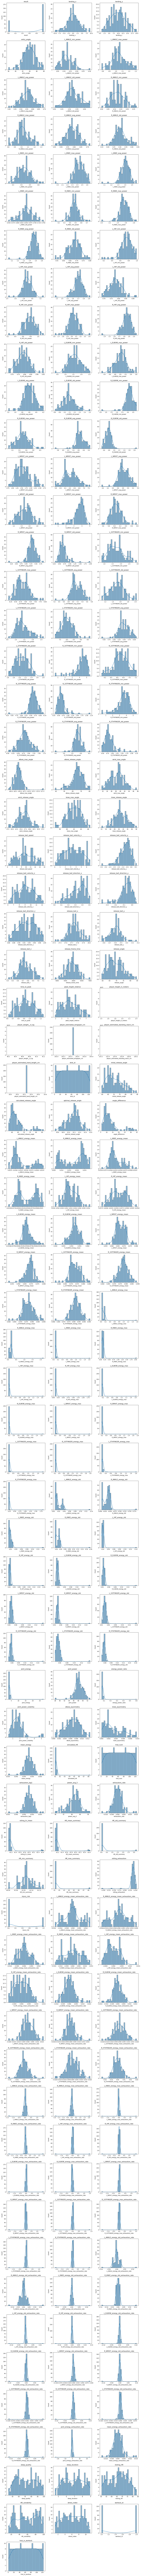

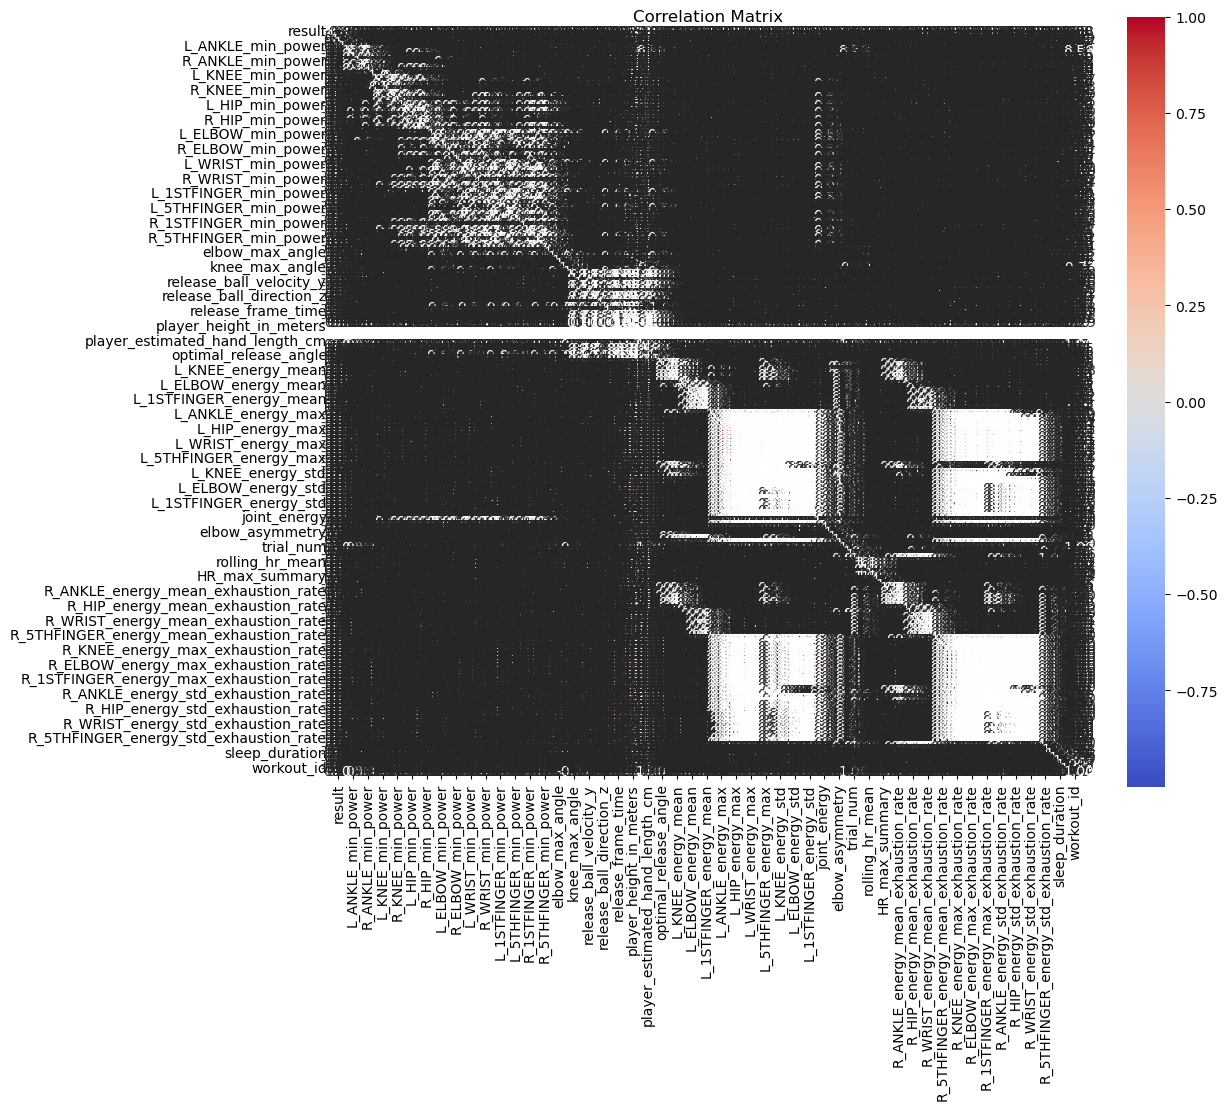

INFO: Highly correlated feature pairs (threshold > 0.80):
INFO:    L_ANKLE_max_power & L_ANKLE_std_power -> correlation: 0.93
INFO:    R_ANKLE_max_power & R_ANKLE_std_power -> correlation: 0.91
INFO:    L_KNEE_max_power & R_KNEE_max_power -> correlation: 0.86
INFO:    L_KNEE_avg_power & R_KNEE_avg_power -> correlation: 0.92
INFO:    L_KNEE_avg_power & L_HIP_avg_power -> correlation: 0.80
INFO:    L_KNEE_std_power & R_KNEE_std_power -> correlation: 0.86
INFO:    R_KNEE_avg_power & L_HIP_avg_power -> correlation: 0.85
INFO:    R_KNEE_avg_power & R_HIP_avg_power -> correlation: 0.85
INFO:    L_HIP_min_power & R_HIP_min_power -> correlation: 0.88
INFO:    L_HIP_max_power & R_HIP_max_power -> correlation: 0.96
INFO:    L_HIP_avg_power & R_HIP_avg_power -> correlation: 0.97
INFO:    L_HIP_std_power & R_HIP_std_power -> correlation: 0.87
INFO:    L_ELBOW_min_power & L_WRIST_min_power -> correlation: 0.89
INFO:    L_ELBOW_min_power & L_1STFINGER_min_power -> correlation: 0.88
INFO:    L_ELBOW_

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4905 - loss: 0.6744 - val_accuracy: 0.3111 - val_loss: 0.7040
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5858 - loss: 0.6961 - val_accuracy: 0.3111 - val_loss: 0.7010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5013 - loss: 0.7173 - val_accuracy: 0.4222 - val_loss: 0.7024
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5774 - loss: 0.6811 - val_accuracy: 0.4444 - val_loss: 0.7112
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6101 - loss: 0.6732 - val_accuracy: 0.6222 - val_loss: 0.6907
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6521 - loss: 0.6837 - val_accuracy: 0.6889 - val_loss: 0.6740
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7580 - loss: 0.6583 - val_accuracy: 0.6889 - val_loss: 0.6673
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7447 - loss: 0.6910 - val_accuracy: 0.6889 - val_loss:

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


INFO: Classification Model Evaluation - Accuracy: 0.6444444444444445, Precision: 0.3125, Recall: 0.5, F1-Score: 0.38461538461538464, ROC-AUC: 0.6714285714285715


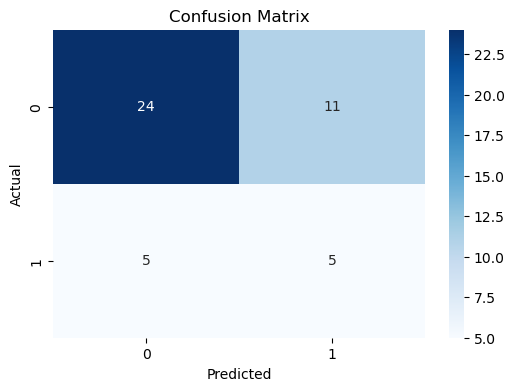

INFO: Injury risk model for L_ANKLE - Evaluation Metrics: {'Accuracy': 0.6444444444444445, 'Precision': 0.3125, 'Recall': 0.5, 'F1-Score': 0.38461538461538464, 'ROC-AUC': 0.6714285714285715}
INFO: All required columns are present.
INFO: Prepared injury data for R_ANKLE: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['R_ANKLE_avg_power', 'R_ANKLE_avg_power_diff', 'R_ANKLE_avg_power_ma_3', 'R_ANKLE_avg_power_ma_5'], Target: R_ANKLE_injury_risk
INFO: All required columns are present.
INFO: Performed temporal train-test split with test size=0.2
INFO: Training data shape: (198, 6), Testing data shape: (50, 6)
INFO: Created LSTM sequences: X_seq shape = (193, 5, 4), y_seq shape = (193,)
INFO: Created LSTM sequences: X_seq shape = (45, 5, 4), y_seq shape = (45,)
INFO: Prepared dataset for training: X_train_seq (193, 5, 4), y_train_seq (193,), X_test_seq (45, 5, 4), y_test_seq (45,)
INFO: Computed class weights: {0: 0.595679012345679, 1: 3.1129032258064515}
c:\Users\ghadf\anaconda3\env

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4845 - loss: 0.7015 - val_accuracy: 0.2889 - val_loss: 0.7080
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5989 - loss: 0.7069 - val_accuracy: 0.3333 - val_loss: 0.6980
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7043 - loss: 0.6839 - val_accuracy: 0.3556 - val_loss: 0.6935
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5696 - loss: 0.7097 - val_accuracy: 0.2667 - val_loss: 0.7127
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5463 - loss: 0.6652 - val_accuracy: 0.2889 - val_loss: 0.7208
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5575 - loss: 0.7185 - val_accuracy: 0.2889 - val_loss: 0.7490
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5703 - loss: 0.6560 - val_accuracy: 0.2889 - val_loss: 0.7445
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5614 - loss: 0.6566 - val_accuracy: 0.2889 - val_loss:

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


INFO: Classification Model Evaluation - Accuracy: 0.6222222222222222, Precision: 0.15384615384615385, Recall: 0.25, F1-Score: 0.19047619047619047, ROC-AUC: 0.5236486486486487


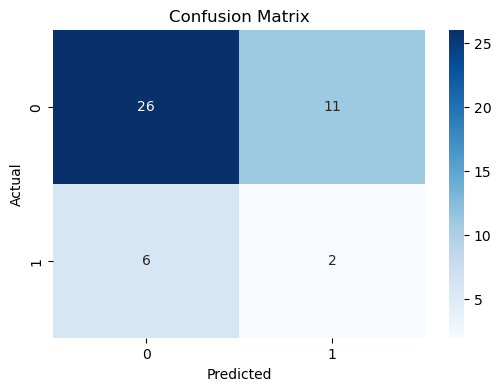

INFO: Injury risk model for R_ANKLE - Evaluation Metrics: {'Accuracy': 0.6222222222222222, 'Precision': 0.15384615384615385, 'Recall': 0.25, 'F1-Score': 0.19047619047619047, 'ROC-AUC': 0.5236486486486487}
INFO: All required columns are present.
INFO: Prepared injury data for L_KNEE: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['L_KNEE_avg_power', 'L_KNEE_avg_power_diff', 'L_KNEE_avg_power_ma_3', 'L_KNEE_avg_power_ma_5'], Target: L_KNEE_injury_risk
INFO: All required columns are present.
INFO: Performed temporal train-test split with test size=0.2
INFO: Training data shape: (198, 6), Testing data shape: (50, 6)
INFO: Created LSTM sequences: X_seq shape = (193, 5, 4), y_seq shape = (193,)
INFO: Created LSTM sequences: X_seq shape = (45, 5, 4), y_seq shape = (45,)
INFO: Prepared dataset for training: X_train_seq (193, 5, 4), y_train_seq (193,), X_test_seq (45, 5, 4), y_test_seq (45,)
INFO: Computed class weights: {0: 0.595679012345679, 1: 3.1129032258064515}
c:\Users\ghadf\anaco

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.4566 - loss: 0.6922 - val_accuracy: 0.7333 - val_loss: 0.6615
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6355 - loss: 0.6560 - val_accuracy: 0.7333 - val_loss: 0.6544
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6881 - loss: 0.6600 - val_accuracy: 0.7333 - val_loss: 0.6382
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6617 - loss: 0.7352 - val_accuracy: 0.6889 - val_loss: 0.6690
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5196 - loss: 0.7109 - val_accuracy: 0.6667 - val_loss: 0.6716
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5764 - loss: 0.7189 - val_accuracy: 0.6889 - val_loss: 0.6560
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6395 - loss: 0.6915 - val_accuracy: 0.7333 - val_loss: 0.6354
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7210 - loss: 0.6473 - val_accuracy: 0.7333 - val_loss:

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001C242B7E200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


INFO: Classification Model Evaluation - Accuracy: 0.7111111111111111, Precision: 0.35714285714285715, Recall: 0.5555555555555556, F1-Score: 0.43478260869565216, ROC-AUC: 0.7654320987654321


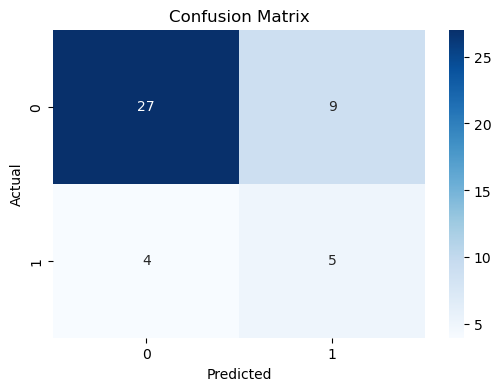

INFO: Injury risk model for L_KNEE - Evaluation Metrics: {'Accuracy': 0.7111111111111111, 'Precision': 0.35714285714285715, 'Recall': 0.5555555555555556, 'F1-Score': 0.43478260869565216, 'ROC-AUC': 0.7654320987654321}
INFO: All required columns are present.
INFO: Prepared injury data for R_KNEE: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['R_KNEE_avg_power', 'R_KNEE_avg_power_diff', 'R_KNEE_avg_power_ma_3', 'R_KNEE_avg_power_ma_5'], Target: R_KNEE_injury_risk
INFO: All required columns are present.
INFO: Performed temporal train-test split with test size=0.2
INFO: Training data shape: (198, 6), Testing data shape: (50, 6)
INFO: Created LSTM sequences: X_seq shape = (193, 5, 4), y_seq shape = (193,)
INFO: Created LSTM sequences: X_seq shape = (45, 5, 4), y_seq shape = (45,)
INFO: Prepared dataset for training: X_train_seq (193, 5, 4), y_train_seq (193,), X_test_seq (45, 5, 4), y_test_seq (45,)
INFO: Computed class weights: {0: 0.5848484848484848, 1: 3.4464285714285716}
c:\Use

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3790 - loss: 0.7134 - val_accuracy: 0.4444 - val_loss: 0.6965
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5227 - loss: 0.6809 - val_accuracy: 0.5333 - val_loss: 0.6877
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5832 - loss: 0.6810 - val_accuracy: 0.5111 - val_loss: 0.6894
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6036 - loss: 0.6747 - val_accuracy: 0.6000 - val_loss: 0.6899
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5887 - loss: 0.6573 - val_accuracy: 0.5778 - val_loss: 0.6956
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6059 - loss: 0.6293 - val_accuracy: 0.5556 - val_loss: 0.7061
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5465 - loss: 0.6561 - val_accuracy: 0.5111 - val_loss: 0.7037
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5323 - loss: 0.6656 - val_accuracy: 0.6667 - val_loss:

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


INFO: Classification Model Evaluation - Accuracy: 0.7333333333333333, Precision: 0.3333333333333333, Recall: 0.5, F1-Score: 0.4, ROC-AUC: 0.5540540540540542


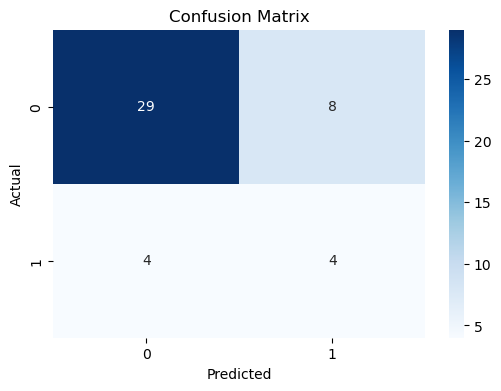

INFO: Injury risk model for R_KNEE - Evaluation Metrics: {'Accuracy': 0.7333333333333333, 'Precision': 0.3333333333333333, 'Recall': 0.5, 'F1-Score': 0.4, 'ROC-AUC': 0.5540540540540542}
INFO: All required columns are present.
INFO: Prepared injury data for L_HIP: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['L_HIP_avg_power', 'L_HIP_avg_power_diff', 'L_HIP_avg_power_ma_3', 'L_HIP_avg_power_ma_5'], Target: L_HIP_injury_risk
INFO: All required columns are present.
INFO: Performed temporal train-test split with test size=0.2
INFO: Training data shape: (198, 6), Testing data shape: (50, 6)
INFO: Created LSTM sequences: X_seq shape = (193, 5, 4), y_seq shape = (193,)
INFO: Created LSTM sequences: X_seq shape = (45, 5, 4), y_seq shape = (45,)
INFO: Prepared dataset for training: X_train_seq (193, 5, 4), y_train_seq (193,), X_test_seq (45, 5, 4), y_test_seq (45,)
INFO: Computed class weights: {0: 0.6185897435897436, 1: 2.608108108108108}
c:\Users\ghadf\anaconda3\envs\data_science_ft

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5506 - loss: 0.7278 - val_accuracy: 0.6222 - val_loss: 0.6874
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5514 - loss: 0.7058 - val_accuracy: 0.6889 - val_loss: 0.6692
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6228 - loss: 0.6427 - val_accuracy: 0.7111 - val_loss: 0.6474
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7112 - loss: 0.6756 - val_accuracy: 0.6667 - val_loss: 0.6374
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6477 - loss: 0.7144 - val_accuracy: 0.6889 - val_loss: 0.6462
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6768 - loss: 0.7072 - val_accuracy: 0.6889 - val_loss: 0.6381
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6744 - loss: 0.7144 - val_accuracy: 0.6889 - val_loss: 0.6276
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6830 - loss: 0.6391 - val_accuracy: 0.6889 - val_loss:

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


INFO: Classification Model Evaluation - Accuracy: 0.6888888888888889, Precision: 0.3333333333333333, Recall: 0.5555555555555556, F1-Score: 0.4166666666666667, ROC-AUC: 0.638888888888889


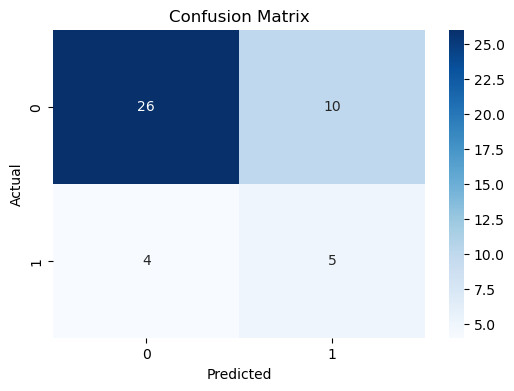

INFO: Injury risk model for L_HIP - Evaluation Metrics: {'Accuracy': 0.6888888888888889, 'Precision': 0.3333333333333333, 'Recall': 0.5555555555555556, 'F1-Score': 0.4166666666666667, 'ROC-AUC': 0.638888888888889}
INFO: All required columns are present.
INFO: Prepared injury data for R_HIP: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['R_HIP_avg_power', 'R_HIP_avg_power_diff', 'R_HIP_avg_power_ma_3', 'R_HIP_avg_power_ma_5'], Target: R_HIP_injury_risk
INFO: All required columns are present.
INFO: Performed temporal train-test split with test size=0.2
INFO: Training data shape: (198, 6), Testing data shape: (50, 6)
INFO: Created LSTM sequences: X_seq shape = (193, 5, 4), y_seq shape = (193,)
INFO: Created LSTM sequences: X_seq shape = (45, 5, 4), y_seq shape = (45,)
INFO: Prepared dataset for training: X_train_seq (193, 5, 4), y_train_seq (193,), X_test_seq (45, 5, 4), y_test_seq (45,)
INFO: Computed class weights: {0: 0.6069182389937107, 1: 2.838235294117647}
c:\Users\ghadf\an

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3152 - loss: 0.6807 - val_accuracy: 0.4444 - val_loss: 0.6877
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4576 - loss: 0.6889 - val_accuracy: 0.4889 - val_loss: 0.6800
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5172 - loss: 0.6590 - val_accuracy: 0.5333 - val_loss: 0.6759
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5258 - loss: 0.6618 - val_accuracy: 0.5333 - val_loss: 0.6906
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4221 - loss: 0.6521 - val_accuracy: 0.5111 - val_loss: 0.7104
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4688 - loss: 0.6577 - val_accuracy: 0.4889 - val_loss: 0.7087
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5041 - loss: 0.6328 - val_accuracy: 0.5333 - val_loss: 0.7028
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5808 - loss: 0.6361 - val_accuracy: 0.5556 - val_loss:

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


INFO: Classification Model Evaluation - Accuracy: 0.6888888888888889, Precision: 0.4, Recall: 0.5454545454545454, F1-Score: 0.46153846153846156, ROC-AUC: 0.5588235294117647


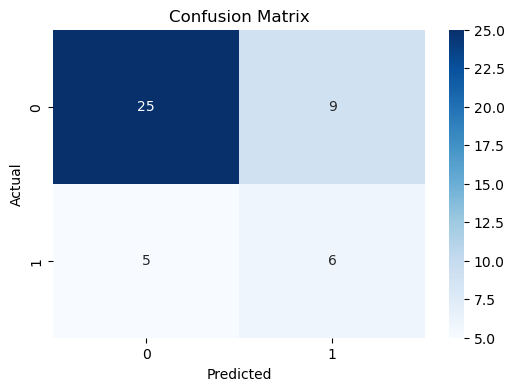

INFO: Injury risk model for R_HIP - Evaluation Metrics: {'Accuracy': 0.6888888888888889, 'Precision': 0.4, 'Recall': 0.5454545454545454, 'F1-Score': 0.46153846153846156, 'ROC-AUC': 0.5588235294117647}
INFO: All required columns are present.
INFO: Prepared injury data for L_ELBOW: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['L_ELBOW_avg_power', 'L_ELBOW_avg_power_diff', 'L_ELBOW_avg_power_ma_3', 'L_ELBOW_avg_power_ma_5'], Target: L_ELBOW_injury_risk
INFO: All required columns are present.
INFO: Performed temporal train-test split with test size=0.2
INFO: Training data shape: (198, 6), Testing data shape: (50, 6)
INFO: Created LSTM sequences: X_seq shape = (193, 5, 4), y_seq shape = (193,)
INFO: Created LSTM sequences: X_seq shape = (45, 5, 4), y_seq shape = (45,)
INFO: Prepared dataset for training: X_train_seq (193, 5, 4), y_train_seq (193,), X_test_seq (45, 5, 4), y_test_seq (45,)
INFO: Computed class weights: {0: 0.5884146341463414, 1: 3.3275862068965516}
c:\Users\ghadf\an

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3295 - loss: 0.6956 - val_accuracy: 0.6222 - val_loss: 0.6903
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4785 - loss: 0.7103 - val_accuracy: 0.7556 - val_loss: 0.6830
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5706 - loss: 0.7169 - val_accuracy: 0.5556 - val_loss: 0.6933
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5408 - loss: 0.6744 - val_accuracy: 0.2222 - val_loss: 0.7499
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5141 - loss: 0.6506 - val_accuracy: 0.2222 - val_loss: 0.8180
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4722 - loss: 0.6550 - val_accuracy: 0.2444 - val_loss: 0.8046
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4587 - loss: 0.6468 - val_accuracy: 0.2222 - val_loss: 0.7786
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4591 - loss: 0.6187 - val_accuracy: 0.2889 - val_loss:

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


INFO: Classification Model Evaluation - Accuracy: 0.7555555555555555, Precision: 0.36363636363636365, Recall: 0.5, F1-Score: 0.42105263157894735, ROC-AUC: 0.6047297297297297


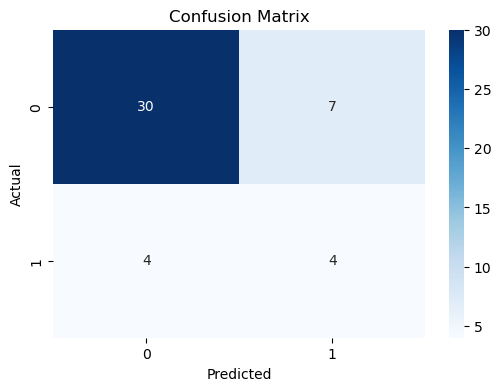

INFO: Injury risk model for L_ELBOW - Evaluation Metrics: {'Accuracy': 0.7555555555555555, 'Precision': 0.36363636363636365, 'Recall': 0.5, 'F1-Score': 0.42105263157894735, 'ROC-AUC': 0.6047297297297297}
INFO: All required columns are present.
INFO: Prepared injury data for R_ELBOW: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['R_ELBOW_avg_power', 'R_ELBOW_avg_power_diff', 'R_ELBOW_avg_power_ma_3', 'R_ELBOW_avg_power_ma_5'], Target: R_ELBOW_injury_risk
INFO: All required columns are present.
INFO: Performed temporal train-test split with test size=0.2
INFO: Training data shape: (198, 6), Testing data shape: (50, 6)
INFO: Created LSTM sequences: X_seq shape = (193, 5, 4), y_seq shape = (193,)
INFO: Created LSTM sequences: X_seq shape = (45, 5, 4), y_seq shape = (45,)
INFO: Prepared dataset for training: X_train_seq (193, 5, 4), y_train_seq (193,), X_test_seq (45, 5, 4), y_test_seq (45,)
INFO: Computed class weights: {0: 0.595679012345679, 1: 3.1129032258064515}
c:\Users\ghadf\

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.8123 - loss: 0.6707 - val_accuracy: 0.8444 - val_loss: 0.6314
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8824 - loss: 0.6159 - val_accuracy: 0.7333 - val_loss: 0.6414
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8035 - loss: 0.6748 - val_accuracy: 0.5556 - val_loss: 0.6637
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7684 - loss: 0.6305 - val_accuracy: 0.5333 - val_loss: 0.6613
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7271 - loss: 0.6497 - val_accuracy: 0.5333 - val_loss: 0.6667
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7502 - loss: 0.6303 - val_accuracy: 0.5556 - val_loss: 0.6779
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7584 - loss: 0.5923 - val_accuracy: 0.5556 - val_loss: 0.7016
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6997 - loss: 0.6244 - val_accuracy: 0.5111 - val_loss:

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


INFO: Classification Model Evaluation - Accuracy: 0.8444444444444444, Precision: 0.0, Recall: 0.0, F1-Score: 0.0, ROC-AUC: 0.45112781954887216


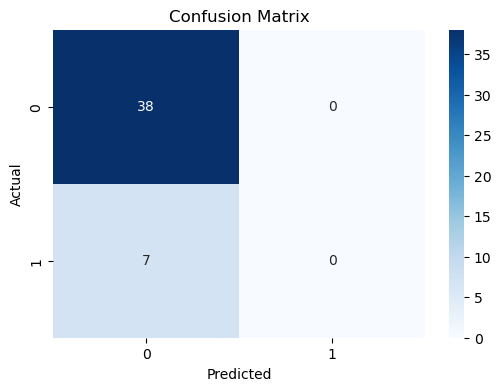

INFO: Injury risk model for R_ELBOW - Evaluation Metrics: {'Accuracy': 0.8444444444444444, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.45112781954887216}
INFO: All required columns are present.
INFO: Prepared injury data for L_WRIST: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['L_WRIST_avg_power', 'L_WRIST_avg_power_diff', 'L_WRIST_avg_power_ma_3', 'L_WRIST_avg_power_ma_5'], Target: L_WRIST_injury_risk
INFO: All required columns are present.
INFO: Performed temporal train-test split with test size=0.2
INFO: Training data shape: (198, 6), Testing data shape: (50, 6)
INFO: Created LSTM sequences: X_seq shape = (193, 5, 4), y_seq shape = (193,)
INFO: Created LSTM sequences: X_seq shape = (45, 5, 4), y_seq shape = (45,)
INFO: Prepared dataset for training: X_train_seq (193, 5, 4), y_train_seq (193,), X_test_seq (45, 5, 4), y_test_seq (45,)
INFO: Computed class weights: {0: 0.5848484848484848, 1: 3.4464285714285716}
c:\Users\ghadf\anaconda3\envs\data_science_ft

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6473 - loss: 0.7115 - val_accuracy: 0.6667 - val_loss: 0.6720
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6318 - loss: 0.6698 - val_accuracy: 0.6444 - val_loss: 0.6615
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6153 - loss: 0.6671 - val_accuracy: 0.6667 - val_loss: 0.6480
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6801 - loss: 0.6473 - val_accuracy: 0.7333 - val_loss: 0.6417
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6453 - loss: 0.7580 - val_accuracy: 0.6444 - val_loss: 0.6486
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7146 - loss: 0.6617 - val_accuracy: 0.6889 - val_loss: 0.6336
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7194 - loss: 0.6883 - val_accuracy: 0.7111 - val_loss: 0.6363
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7413 - loss: 0.6726 - val_accuracy: 0.6889 - val_loss:

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


INFO: Classification Model Evaluation - Accuracy: 0.7333333333333333, Precision: 0.25, Recall: 0.25, F1-Score: 0.25, ROC-AUC: 0.5168918918918919


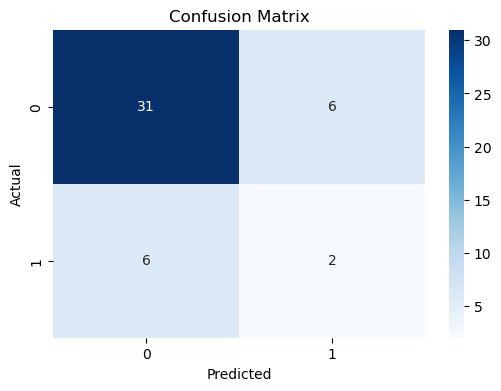

INFO: Injury risk model for L_WRIST - Evaluation Metrics: {'Accuracy': 0.7333333333333333, 'Precision': 0.25, 'Recall': 0.25, 'F1-Score': 0.25, 'ROC-AUC': 0.5168918918918919}
INFO: All required columns are present.
INFO: Prepared injury data for R_WRIST: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['R_WRIST_avg_power', 'R_WRIST_avg_power_diff', 'R_WRIST_avg_power_ma_3', 'R_WRIST_avg_power_ma_5'], Target: R_WRIST_injury_risk
INFO: All required columns are present.
INFO: Performed temporal train-test split with test size=0.2
INFO: Training data shape: (198, 6), Testing data shape: (50, 6)
INFO: Created LSTM sequences: X_seq shape = (193, 5, 4), y_seq shape = (193,)
INFO: Created LSTM sequences: X_seq shape = (45, 5, 4), y_seq shape = (45,)
INFO: Prepared dataset for training: X_train_seq (193, 5, 4), y_train_seq (193,), X_test_seq (45, 5, 4), y_test_seq (45,)
INFO: Computed class weights: {0: 0.5848484848484848, 1: 3.4464285714285716}
c:\Users\ghadf\anaconda3\envs\data_science_

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.1505 - loss: 0.7124 - val_accuracy: 0.2222 - val_loss: 0.7043
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3022 - loss: 0.7389 - val_accuracy: 0.4444 - val_loss: 0.6945
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5382 - loss: 0.7390 - val_accuracy: 0.4889 - val_loss: 0.6876
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5368 - loss: 0.6879 - val_accuracy: 0.5556 - val_loss: 0.6803
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6037 - loss: 0.7022 - val_accuracy: 0.5556 - val_loss: 0.6783
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6695 - loss: 0.6845 - val_accuracy: 0.5333 - val_loss: 0.6778
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6355 - loss: 0.5976 - val_accuracy: 0.4444 - val_loss: 0.6947
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5943 - loss: 0.6341 - val_accuracy: 0.3778 - val_loss: 0.

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


INFO: Classification Model Evaluation - Accuracy: 0.6222222222222222, Precision: 0.23076923076923078, Recall: 0.3, F1-Score: 0.2608695652173913, ROC-AUC: 0.52


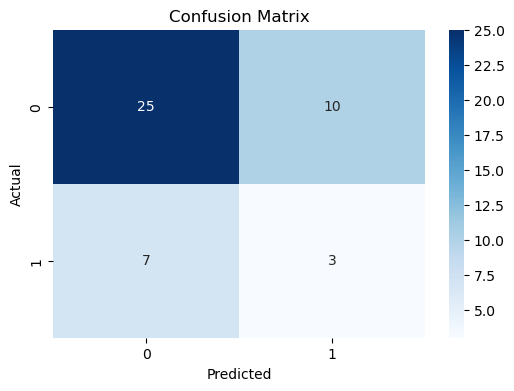

INFO: Injury risk model for R_WRIST - Evaluation Metrics: {'Accuracy': 0.6222222222222222, 'Precision': 0.23076923076923078, 'Recall': 0.3, 'F1-Score': 0.2608695652173913, 'ROC-AUC': 0.52}



Joint Injury Model Evaluation Metrics
         Accuracy  Precision    Recall  F1-Score   ROC-AUC
Joint                                                     
L_ANKLE  0.644444   0.312500  0.500000  0.384615  0.671429
R_ANKLE  0.622222   0.153846  0.250000  0.190476  0.523649
L_KNEE   0.711111   0.357143  0.555556  0.434783  0.765432
R_KNEE   0.733333   0.333333  0.500000  0.400000  0.554054
L_HIP    0.688889   0.333333  0.555556  0.416667  0.638889
R_HIP    0.688889   0.400000  0.545455  0.461538  0.558824
L_ELBOW  0.755556   0.363636  0.500000  0.421053  0.604730
R_ELBOW  0.844444   0.000000  0.000000  0.000000  0.451128
L_WRIST  0.733333   0.250000  0.250000  0.250000  0.516892
R_WRIST  0.622222   0.230769  0.300000  0.260870  0.520000


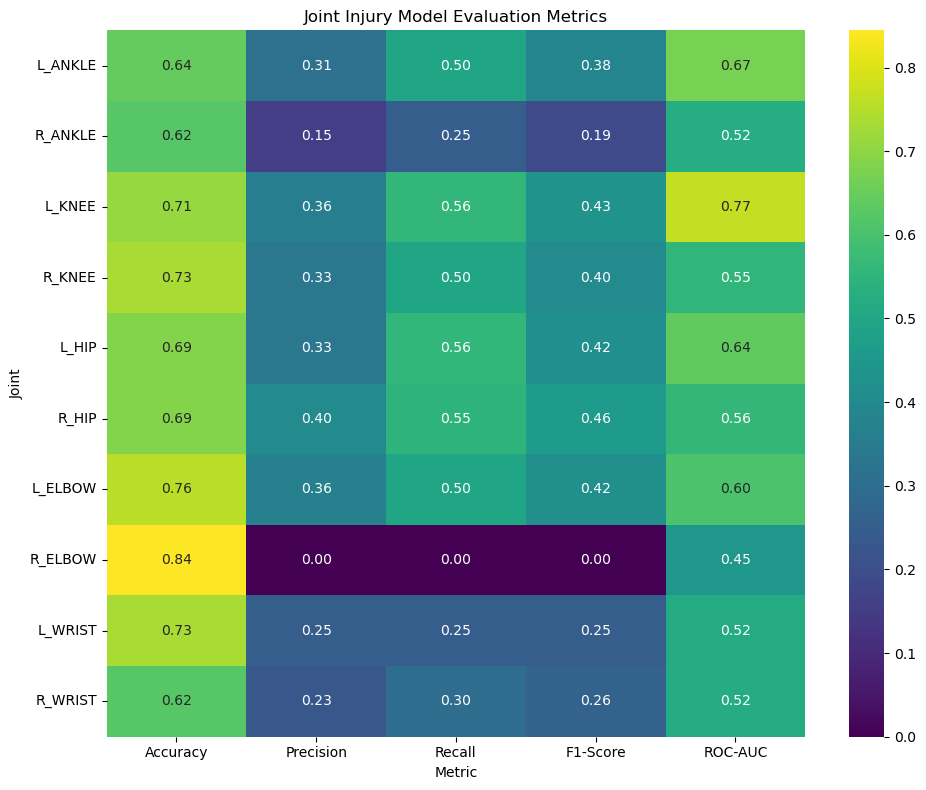

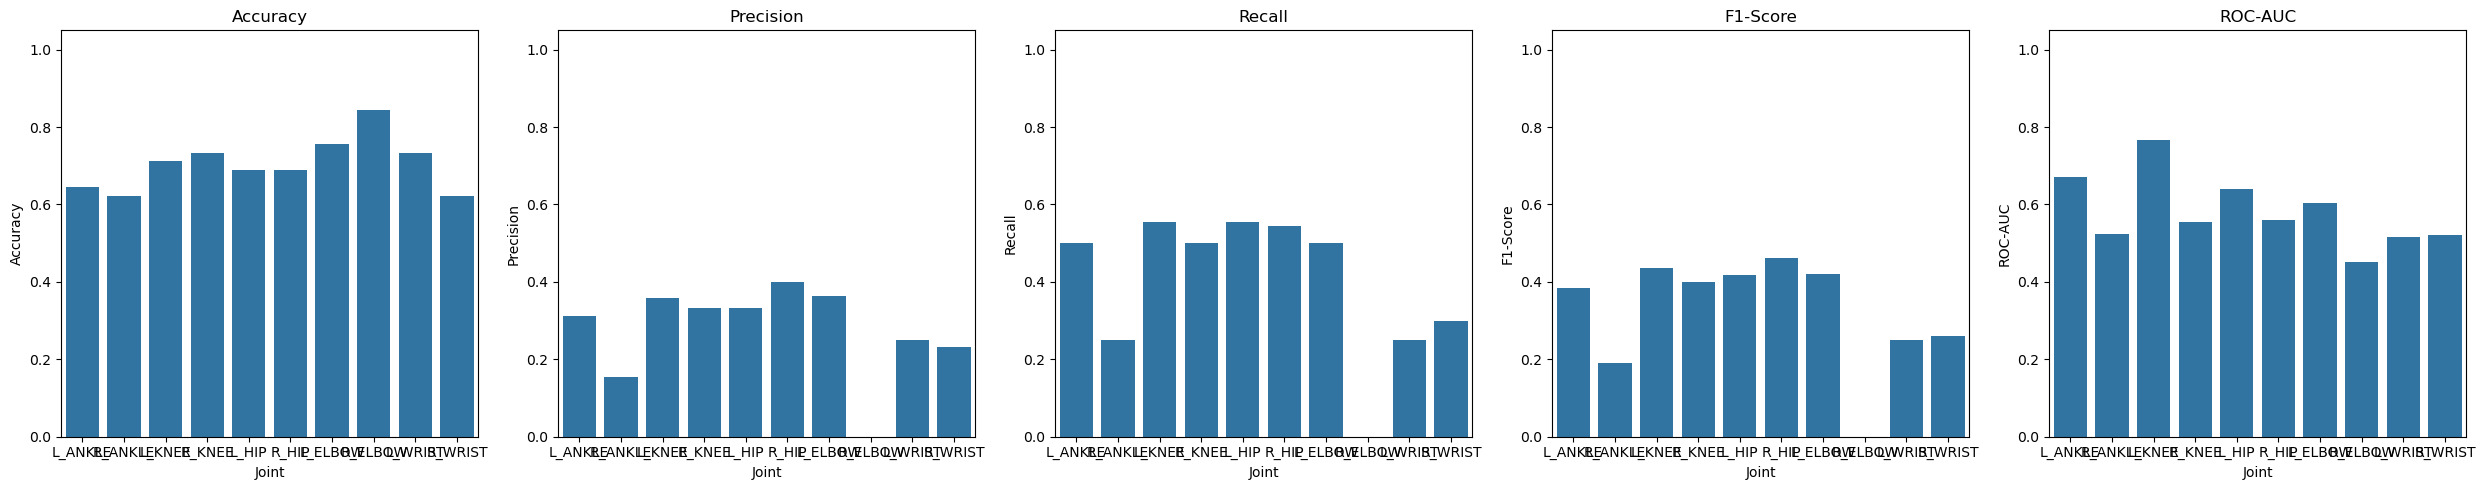

In [ ]:
import numpy as np
import pandas as pd
import json
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import shap
from scipy.stats import linregress
from sklearn.utils.class_weight import compute_class_weight

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
from tensorflow.keras.layers import Bidirectional  # ensure import is available

###############################################################################
# HELPER FUNCTION FOR DEBUG OUTPUTS
###############################################################################
def _print_debug_info(step_name, df, new_columns=None, debug=False):
    """
    Prints debug information about a DataFrame after a processing step.
    
    When debug=True, prints:
      - The step name.
      - The DataFrame shape.
      - For each new column (if provided), its data type and a sample of unique values.
    
    When debug=False, prints a simple message indicating step completion.
    """
    if debug:
        logging.info(f"Step [{step_name}]: DataFrame shape = {df.shape}")
        if new_columns:
            logging.info(f"New columns added: {new_columns}")
            for col in new_columns:
                sample = df[col].dropna().unique()[:5]
                logging.info(f" - {col}: dtype={df[col].dtype}, sample values={sample}")
    else:
        logging.info(f"Step [{step_name}] completed.")


def check_required_columns(df, required_columns):
    """
    Checks if all required columns exist in the DataFrame.
    
    Parameters:
      - df (pd.DataFrame): The input DataFrame.
      - required_columns (list): List of column names required.
      
    Returns:
      - bool: True if all exist, False otherwise.
    """
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        logging.error(f"Missing required columns: {missing}")
        return False
    logging.info("All required columns are present.")
    return True

def custom_dynamic_threshold(series):
    """
    Computes a dynamic threshold based on the series distribution.
    For example, it returns mean + 0.5 * standard deviation.
    
    Parameters:
      - series (pd.Series): The input data series.
      
    Returns:
      - threshold (float): The computed threshold.
    """
    return series.mean() + 0.5 * series.std()


###############################################################################
# DATA LOADING AND BASE FEATURE ENGINEERING
###############################################################################
def validate_base_metrics(df, expected_ranges, debug=False):
    """
    Validates that key metrics in the dataset fall within the expected ranges.
    
    Parameters:
      - df (pd.DataFrame): The input DataFrame containing the base metrics.
      - expected_ranges (dict): A dictionary where keys are column names and values are tuples 
                                (expected_min, expected_max).
      - debug (bool): If True, prints detailed debug outputs.
      
    Returns:
      - valid (bool): True if all metrics fall within the expected ranges, False otherwise.
    """
    valid = True
    for col, (exp_min, exp_max) in expected_ranges.items():
        if col not in df.columns:
            logging.warning(f"Expected metric '{col}' is not in the dataset.")
            continue
        actual_min = df[col].min()
        actual_max = df[col].max()
        if debug:
            logging.info(f"Validating '{col}': expected range=({exp_min}, {exp_max}), actual range=({actual_min}, {actual_max})")
        if actual_min < exp_min or actual_max > exp_max:
            logging.warning(
                f"Metric '{col}' is out of expected range! "
                f"Expected: ({exp_min}, {exp_max}), Actual: ({actual_min}, {actual_max})"
            )
            valid = False
    return valid


def load_final_ml_dataset(filepath, debug=False):
    """
    Loads the final ML dataset.
    
    Parameters:
      - filepath (str): Path to the CSV file.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - ml_df (pd.DataFrame): Loaded DataFrame.
    """
    try:
        ml_df = pd.read_csv(filepath)
        logging.info(f"Loaded final ML dataset from {filepath} with shape {ml_df.shape}")
    except Exception as e:
        logging.error(f"Error loading final ML dataset: {e}")
        sys.exit(1)
    
    _print_debug_info("load_final_ml_dataset", ml_df, debug=debug)
    return ml_df


def compute_trial_differentials(ml_df, diff_columns, debug=False):
    """
    Computes trial-to-trial differential features for specified columns.
    
    Parameters:
      - ml_df (pd.DataFrame): Input DataFrame.
      - diff_columns (list): List of columns for which to compute differences.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - diff_df (pd.DataFrame): DataFrame with differential features.
    """
    available_cols = ml_df.columns.tolist()
    logging.info(f"Available columns in the dataset: {available_cols}")

    diff_df = ml_df.sort_values('trial_id').reset_index(drop=True)
    
    for col in diff_columns:
        if col not in diff_df.columns:
            logging.error(f"Column '{col}' not found in the dataset.")
            sys.exit(1)
        diff_feature = f"{col}_diff"
        diff_df[diff_feature] = diff_df[col].diff()
        if debug:
            sample_diffs = diff_df[diff_feature].dropna().head().tolist()
            logging.info(f"Computed differential feature '{diff_feature}' for column '{col}', sample values: {sample_diffs}")
    
    diff_df.fillna(0, inplace=True)
    new_cols = [f"{col}_diff" for col in diff_columns]
    _print_debug_info("compute_trial_differentials", diff_df, new_columns=new_cols, debug=debug)
    return diff_df


def merge_differentials(original_df, diff_df, debug=False):
    """
    Merges differential features from diff_df into the original DataFrame.
    
    Parameters:
      - original_df (pd.DataFrame): Original DataFrame.
      - diff_df (pd.DataFrame): DataFrame containing differential features.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - merged_df (pd.DataFrame): DataFrame with differential features merged.
    """
    merged_df = original_df.copy()
    diff_features = [col for col in diff_df.columns if col.endswith('_diff')]
    merged_df = pd.concat([merged_df, diff_df[diff_features]], axis=1)
    
    if debug:
        logging.info(f"Merged differential features. New shape: {merged_df.shape}")
        logging.info(f"Added differential columns: {diff_features}")
    else:
        logging.info("Differential features merged.")
    
    _print_debug_info("merge_differentials", merged_df, new_columns=diff_features, debug=debug)
    return merged_df


###############################################################################
# ENHANCED DATA ANALYSIS FUNCTIONS
###############################################################################
def analyze_missing_values(df, debug=False):
    """
    Analyzes missing values by column.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, logs detailed missing value information.
    
    Returns:
      - missing_df (pd.DataFrame): DataFrame with missing value counts and percentages.
    """
    missing = df.isnull().sum()
    missing_percent = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({'missing_count': missing, 'missing_percent': missing_percent})
    if debug:
        missing_info = missing_df[missing_df['missing_count'] > 0]
        if not missing_info.empty:
            logging.info("Missing values detected:\n{}".format(missing_info))
        else:
            logging.info("No missing values detected.")
    return missing_df


def print_distribution_summary(df, feature):
    """
    Logs summary statistics for a feature.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - feature (str): Feature name.
    """
    series = df[feature].dropna()
    mean_val = series.mean()
    median_val = series.median()
    std_val = series.std()
    skew_val = series.skew()
    kurtosis_val = series.kurtosis()
    
    # Outlier calculation using 1.5*IQR rule
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    
    logging.info(
        f"Feature '{feature}': mean={mean_val:.4f}, median={median_val:.4f}, std={std_val:.4f}, "
        f"skewness={skew_val:.4f}, kurtosis={kurtosis_val:.4f}, outliers={len(outliers)}"
    )


def plot_feature_distributions(df, features, bins=30):
    """
    Plots histograms with KDE overlays for specified features.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - features (list): List of feature names.
      - bins (int): Number of histogram bins.
    """
    num_features = len(features)
    ncols = 3
    nrows = (num_features + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 5, nrows * 4))
    for i, feature in enumerate(features):
        print_distribution_summary(df, feature)
        plt.subplot(nrows, ncols, i+1)
        sns.histplot(df[feature], bins=bins, kde=True)
        plt.title(f'{feature}')
    plt.tight_layout()
    plt.show()


def print_highly_correlated_pairs(df, features, threshold=0.8):
    """
    Logs pairs of features that have a correlation above the threshold.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - features (list): List of feature names.
      - threshold (float): Correlation threshold.
    """
    corr_matrix = df[features].corr().abs()
    correlated_pairs = []
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            if corr_matrix.iloc[i, j] > threshold:
                correlated_pairs.append((features[i], features[j], corr_matrix.iloc[i, j]))
    if correlated_pairs:
        logging.info("Highly correlated feature pairs (threshold > {:.2f}):".format(threshold))
        for a, b, corr_val in correlated_pairs:
            logging.info(f"   {a} & {b} -> correlation: {corr_val:.2f}")
    else:
        logging.info("No highly correlated feature pairs found above the threshold.")


def plot_correlation_matrix(df, features=None, figsize=(12, 10), corr_threshold=0.8):
    """
    Plots the correlation matrix and logs highly correlated feature pairs.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - features (list): List of feature names. If None, uses all columns.
      - figsize (tuple): Figure size.
      - corr_threshold (float): Threshold for high correlation.
    """
    if features is None:
        features = df.columns.tolist()
    corr = df[features].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Correlation Matrix")
    plt.show()
    
    print_highly_correlated_pairs(df, features, threshold=corr_threshold)


def analyze_temporal_trends(df, time_column, features, aggregate_func='mean', debug=False):
    """
    Plots temporal trends for specified features and computes trend slopes.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - time_column (str): Name of the time column.
      - features (list): List of features to analyze.
      - aggregate_func (str): Aggregation function (e.g., 'mean').
      - debug (bool): If True, logs detailed debug outputs.
    """
    if time_column not in df.columns:
        logging.error(f"Time column '{time_column}' not found.")
        return
    if not pd.api.types.is_datetime64_any_dtype(df[time_column]):
        df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
    df_sorted = df.sort_values(time_column)
    df_grouped = df_sorted.groupby(time_column)[features].agg(aggregate_func).reset_index()
    
    plt.figure(figsize=(15, 8))
    slopes = {}
    for feature in features:
        sns.lineplot(data=df_grouped, x=time_column, y=feature, label=feature)
        time_ordinals = df_grouped[time_column].map(pd.Timestamp.toordinal)
        slope, intercept, r_value, p_value, std_err = linregress(time_ordinals, df_grouped[feature])
        slopes[feature] = slope
        logging.info(f"Temporal trend for '{feature}': slope={slope:.4f}, r_value={r_value:.2f}, p_value={p_value:.4f}")
    plt.title("Temporal Trends of Features")
    plt.xlabel("Time")
    plt.ylabel(f"{aggregate_func.capitalize()} Value")
    plt.legend()
    plt.show()
    
    _print_debug_info("analyze_temporal_trends", df_grouped, new_columns=features, debug=debug)


def validate_temporal_consistency(df, workout_col='workout_id', trial_col='trial_in_workout', debug=False):
    """
    Validates that within each workout, the trial numbers are consecutive starting at 1.
    
    For each unique workout (identified by workout_col), this function checks that the
    trial_in_workout column is sorted and that the trials form a consecutive sequence.
    
    Parameters:
      - df (pd.DataFrame): The DataFrame containing workout data.
      - workout_col (str): Column name that identifies the workout (default 'workout_id').
      - trial_col (str): Column name that holds the trial number within the workout (default 'trial_in_workout').
      - debug (bool): If True, logs detailed information.
    
    Returns:
      - bool: True if all workouts are consistent; False otherwise.
    """
    valid = True
    unique_workouts = df[workout_col].unique()
    for wid in unique_workouts:
        workout_df = df[df[workout_col] == wid].sort_values(by=trial_col)
        expected_trials = list(range(1, workout_df.shape[0] + 1))
        actual_trials = workout_df[trial_col].tolist()
        if actual_trials != expected_trials:
            logging.error(
                f"Temporal inconsistency in workout {wid}: "
                f"expected trial numbers {expected_trials} but got {actual_trials}."
            )
            valid = False
        else:
            if debug:
                logging.info(
                    f"Workout {wid} validated: trial_in_workout is consecutive from 1 to {workout_df.shape[0]}."
                )
    return valid


def fatigue_injury_interaction_analysis(data, features_exhaustion, target_exhaustion, debug=False):
    """
    Analyzes fatigue-injury interactions and computes joint-specific injury risk predictions.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - features_exhaustion (list): Features for exhaustion prediction.
      - target_exhaustion (str): Target variable for exhaustion.
      - debug (bool): If True, prints detailed debug outputs.
    """
    step = "fatigue_injury_interaction_analysis"
    
    # Global Fatigue-Injury Matrix
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        fatigue_bins = pd.qcut(data['by_trial_exhaustion_score'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        joint_energy_bins = pd.qcut(data['joint_energy'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        fatigue_injury_matrix = pd.crosstab(fatigue_bins, joint_energy_bins, normalize='index')
        plt.figure(figsize=(10, 8))
        sns.heatmap(fatigue_injury_matrix, annot=True, cmap='viridis')
        plt.title('Global Fatigue-Injury Matrix (Normalized by Fatigue Quartiles)')
        plt.xlabel('Joint Energy Quartiles')
        plt.ylabel('Fatigue Score Quartiles')
        plt.show()
    else:
        logging.info("Required columns for global fatigue-injury matrix not found; skipping this analysis.")
    
    # Joint-Specific Injury Risk Predictions
    joint_energy_cols = [col for col in data.columns if '_energy' in col 
                         and not any(x in col for x in ['by_trial', 'overall', 'joint_energy'])]
    for col in joint_energy_cols:
        rolling_window = 5
        rolling_col = f"{col}_rolling_sum"
        data[rolling_col] = data[col].rolling(window=rolling_window, min_periods=1).sum()
        threshold = data[rolling_col].quantile(0.75)
        risk_col = f"{col}_injury_risk"
        data[risk_col] = (data[rolling_col] > threshold).astype(int)
        logging.info(f"Computed joint-specific injury risk for {col} as '{risk_col}' using a rolling window of {rolling_window} trials and threshold {threshold:.2f}.")
    
    # Interaction Analysis
    if 'player_height_in_meters' in data.columns and 'joint_energy' in data.columns:
        X_interaction = data[features_exhaustion].copy()
        if 'player_height_in_meters' in X_interaction.columns and 'joint_energy' in X_interaction.columns:
            X_interaction['height_energy_interaction'] = X_interaction['player_height_in_meters'] * X_interaction['joint_energy']
            X_interaction.fillna(method='ffill', inplace=True)
            X_interaction.fillna(method='bfill', inplace=True)
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_interaction, data[target_exhaustion])
            explainer_interaction = shap.TreeExplainer(model)
            shap_interaction = explainer_interaction.shap_values(X_interaction)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_interaction, X_interaction, max_display=15)
            plt.title('SHAP Values with Interaction Effects')
            plt.show()
        else:
            logging.info("Required columns for interaction effect missing; skipping SHAP analysis.")
    else:
        logging.info("Required columns for interaction effect not found; skipping SHAP analysis.")
    
    _print_debug_info(step, data, debug=debug)


def explore_dataset(df, debug=False):
    """
    Runs a series of analyses to understand the dataset.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
    """
    logging.info("----- Exploring Dataset -----")
    logging.info(f"Dataset Shape: {df.shape}")
    logging.info(f"Columns: {df.columns.tolist()}")
    
    _ = analyze_missing_values(df, debug=debug)
    logging.info("Descriptive Statistics:\n{}".format(df.describe()))
    
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    logging.info(f"Numeric Features: {numeric_features}")
    
    plot_feature_distributions(df, numeric_features)
    plot_correlation_matrix(df, numeric_features)


###############################################################################
# ADDITIONAL FEATURE ENGINEERING
###############################################################################
def add_moving_average_features(df, features, windows=[3, 5], debug=False):
    """
    Adds moving average features for specified columns.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - features (list): List of features to compute moving averages for.
      - windows (list): List of window sizes.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - df (pd.DataFrame): Updated DataFrame.
    """
    for feature in features:
        for window in windows:
            new_feature = f"{feature}_ma_{window}"
            df[new_feature] = df[feature].rolling(window=window, min_periods=1).mean()
            if debug:
                logging.info(f"Added moving average feature: {new_feature}")
    return df


def add_injury_risk_labels_per_joint(df, joint_prefixes, risk_feature_suffix='_avg_power_diff', quantile_threshold=0.75, dynamic_threshold_func=None, debug=False):
    """
    Computes and adds a binary injury risk label for each joint.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - joint_prefixes (list): List of joint prefixes (e.g., ["L_ANKLE", "R_KNEE"]).
      - risk_feature_suffix (str): Suffix used to identify the risk feature.
      - quantile_threshold (float): Quantile threshold to determine risk (used if dynamic_threshold_func is None).
      - dynamic_threshold_func (callable): Optional function to compute the threshold. It should accept a pandas Series and return a threshold.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - df (pd.DataFrame): Updated DataFrame with injury risk labels.
    """
    new_cols = []
    for joint in joint_prefixes:
        col_name = f"{joint}{risk_feature_suffix}"
        label_name = f"{joint}_injury_risk"
        if col_name not in df.columns:
            logging.warning(f"Risk feature column '{col_name}' not found for joint {joint}. Skipping label generation.")
            continue
        
        # Compute threshold using dynamic function if provided; otherwise use quantile_threshold.
        if dynamic_threshold_func is not None:
            threshold = dynamic_threshold_func(df[col_name])
            logging.info(f"Dynamic threshold for {joint} computed as {threshold:.4f}.")
        else:
            threshold = df[col_name].quantile(quantile_threshold)
        
        df[label_name] = (df[col_name] > threshold).astype(int)
        new_cols.append(label_name)
        logging.info(f"Added injury risk label '{label_name}' based on '{col_name}' with threshold={threshold:.4f}.")
    _print_debug_info("add_injury_risk_labels_per_joint", df, new_columns=new_cols, debug=debug)
    return df

def add_volatility_features(df, features, window=5, suffix='_volatility', debug=False):
    """
    Adds volatility features (rolling standard deviation) for specified columns.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - features (list): List of feature names for which to compute volatility.
      - window (int): The rolling window size.
      - suffix (str): Suffix to append to the original column name for the volatility feature.
      - debug (bool): If True, prints detailed debug outputs.
      
    Returns:
      - df (pd.DataFrame): Updated DataFrame with new volatility features.
    """
    new_cols = []
    for feature in features:
        new_feature = f"{feature}{suffix}"
        # Compute the rolling standard deviation (volatility)
        df[new_feature] = df[feature].rolling(window=window, min_periods=1).std()
        new_cols.append(new_feature)
        if debug:
            sample_vol = df[new_feature].dropna().unique()[:5]
            logging.info(f"Added volatility feature: {new_feature}, sample values={sample_vol}")
    _print_debug_info("add_volatility_features", df, new_columns=new_cols, debug=debug)
    return df

def simulate_workouts(df, debug=False):
    """
    Simulates a second workout from the current single-workout data.
    
    Assumptions:
      - The input DataFrame corresponds to one workout with 125 trials.
      - Adds a 'workout_id' column (1 for the original workout).
      - Creates a duplicate for a second workout (workout_id=2) and resets the trial counter.
      - Simulates deterioration in fake body metrics across the workout:
          - sleep_quality decreases by up to 10 points.
          - sleep_duration decreases by up to 0.5 hours.
          - resting_HR increases by up to 5 bpm.
          - HR_variability decreases by up to 10 ms.
          - stress_index increases by up to 2 points.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame for a single workout.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - df_combined (pd.DataFrame): DataFrame containing both workouts.
    """
    df = df.copy()
    num_trials = df.shape[0]
    
    # Mark the original workout and add trial counter.
    df['workout_id'] = 1
    df['trial_in_workout'] = np.arange(1, num_trials + 1)
    
    # Create a copy for the second workout.
    df_workout2 = df.copy()
    df_workout2['workout_id'] = 2
    df_workout2['trial_in_workout'] = np.arange(1, num_trials + 1)
    
    # Simulate deterioration in the fake body metrics for workout 2.
    max_trial = num_trials  # e.g., 125
    df_workout2['sleep_quality'] = df_workout2['sleep_quality'] - (df_workout2['trial_in_workout'] / max_trial) * 10
    df_workout2['sleep_duration'] = df_workout2['sleep_duration'] - (df_workout2['trial_in_workout'] / max_trial) * 0.5
    df_workout2['resting_HR'] = df_workout2['resting_HR'] + (df_workout2['trial_in_workout'] / max_trial) * 5
    df_workout2['HR_variability'] = df_workout2['HR_variability'] - (df_workout2['trial_in_workout'] / max_trial) * 10
    df_workout2['stress_index'] = df_workout2['stress_index'] + (df_workout2['trial_in_workout'] / max_trial) * 2
    
    if debug:
        logging.info("Simulated workout 2 body metrics deterioration:")
        for col in ['sleep_quality', 'sleep_duration', 'resting_HR', 'HR_variability', 'stress_index']:
            logging.info(f"{col} (workout 2) sample: {df_workout2[col].head().tolist()}")
    
    # Concatenate both workouts.
    df_combined = pd.concat([df, df_workout2], ignore_index=True)
    if debug:
        logging.info(f"After simulating workouts, combined data shape: {df_combined.shape}")
    return df_combined


def add_fake_body_metrics(df, debug=False, random_state=42):
    """
    Adds fake body metrics to the DataFrame to simulate wearable or self-reported health data.
    New columns include:
      - sleep_quality: a score between 50 and 100 (higher is better)
      - sleep_duration: hours of sleep per night (between 5 and 9)
      - resting_HR: resting heart rate (between 50 and 80 bpm)
      - HR_variability: heart rate variability in milliseconds (between 20 and 100)
      - stress_index: a stress level from 1 to 10 (higher indicates more stress)
      
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
      - random_state (int): Seed for random number generator.
      
    Returns:
      - df (pd.DataFrame): Updated DataFrame with the new fake body metrics.
    """
    np.random.seed(random_state)
    
    # If any column already exists, we leave it as is.
    if 'sleep_quality' not in df.columns:
        df['sleep_quality'] = np.random.uniform(50, 100, size=len(df))
        if debug:
            logging.info(f"Added fake 'sleep_quality' feature with sample values: {df['sleep_quality'].head().tolist()}")
    
    if 'sleep_duration' not in df.columns:
        df['sleep_duration'] = np.random.uniform(5, 9, size=len(df))
        if debug:
            logging.info(f"Added fake 'sleep_duration' feature with sample values: {df['sleep_duration'].head().tolist()}")
    
    if 'resting_HR' not in df.columns:
        df['resting_HR'] = np.random.uniform(50, 80, size=len(df))
        if debug:
            logging.info(f"Added fake 'resting_HR' feature with sample values: {df['resting_HR'].head().tolist()}")
    
    if 'HR_variability' not in df.columns:
        df['HR_variability'] = np.random.uniform(20, 100, size=len(df))
        if debug:
            logging.info(f"Added fake 'HR_variability' feature with sample values: {df['HR_variability'].head().tolist()}")
    
    if 'stress_index' not in df.columns:
        df['stress_index'] = np.random.uniform(1, 10, size=len(df))
        if debug:
            logging.info(f"Added fake 'stress_index' feature with sample values: {df['stress_index'].head().tolist()}")
    
    new_metrics = ['sleep_quality', 'sleep_duration', 'resting_HR', 'HR_variability', 'stress_index']
    _print_debug_info("add_fake_body_metrics", df, new_columns=new_metrics, debug=debug)
    return df



def prepare_injury_data(df, joint_prefix, risk_feature_suffix='_avg_power_diff', debug=False):
    """
    Extracts features, target, and shot IDs for injury risk prediction for a given joint.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - joint_prefix (str): Joint prefix (e.g., "L_ANKLE").
      - risk_feature_suffix (str): Suffix for the risk feature.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - X (np.array): Feature array.
      - y (np.array): Target array.
      - shot_ids (np.array): Array of shot IDs.
    """
    required = [
        f"{joint_prefix}_avg_power",
        f"{joint_prefix}{risk_feature_suffix}",
        f"{joint_prefix}_avg_power_ma_3",
        f"{joint_prefix}_avg_power_ma_5",
        f"{joint_prefix}_injury_risk"
    ]
    if not check_required_columns(df, required):
        logging.error(f"Not all required columns for joint {joint_prefix} are present.")
        sys.exit(1)
    
    features = [
        f"{joint_prefix}_avg_power",
        f"{joint_prefix}{risk_feature_suffix}",
        f"{joint_prefix}_avg_power_ma_3",
        f"{joint_prefix}_avg_power_ma_5"
    ]
    target = f"{joint_prefix}_injury_risk"
    X = df[features].values
    y = df[target].values
    if 'shot_id' in df.columns:
        shot_ids = df['shot_id'].values
    else:
        logging.error("Missing 'shot_id' column in the input DataFrame for injury data.")
        sys.exit(1)
    logging.info(f"Prepared injury data for {joint_prefix}: X shape={X.shape}, y shape={y.shape}")
    if debug:
        logging.info(f"Features used: {features}, Target: {target}")
    return X, y, shot_ids


def prepare_joint_features(data, debug=False):
    """
    Aggregates joint-level energy and power, creates additional biomechanical features,
    computes a simulated heart rate, and adds a new feature for joint power volatility.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame with new features.
    """
    step = "prepare_joint_features"
    new_cols = []

    # Rename participant anthropometrics if available.
    if 'height_in_meters' in data.columns and 'weight__in_kg' in data.columns:
        data['player_height_in_meters'] = data['height_in_meters']
        data['player_weight__in_kg'] = data['weight__in_kg']
        data.drop(['height_in_meters', 'weight__in_kg'], axis=1, inplace=True, errors='ignore')
        new_cols.extend(['player_height_in_meters', 'player_weight__in_kg'])
        logging.info("Renamed participant anthropometrics.")
    else:
        logging.warning("Participant anthropometric columns not found during renaming.")
    
    # Identify joint energy and power columns.
    joint_energy_columns = [col for col in data.columns if '_energy' in col and not ('by_trial' in col or 'overall' in col)]
    joint_power_columns = [col for col in data.columns if col.endswith('_avg_power')]
    
    logging.info(f"Identified {len(joint_energy_columns)} joint energy and {len(joint_power_columns)} joint power columns.")
    if not joint_energy_columns:
        logging.error("No joint energy columns found. Check naming conventions.")
        sys.exit(1)
    if not joint_power_columns:
        logging.error("No joint power columns found. Check naming conventions.")
        sys.exit(1)
    
    # Create aggregated joint metrics.
    data['joint_energy'] = data[joint_energy_columns].sum(axis=1)
    data['joint_power'] = data[joint_power_columns].sum(axis=1)
    new_cols.extend(['joint_energy', 'joint_power'])
    logging.info("Created aggregated 'joint_energy' and 'joint_power'.")
    
    # Add new interaction feature: energy_power_ratio.
    epsilon = 1e-6  # Avoid division by zero.
    data['energy_power_ratio'] = data['joint_energy'] / (data['joint_power'] + epsilon)
    new_cols.append('energy_power_ratio')
    logging.info("Created 'energy_power_ratio' as interaction feature between joint_energy and joint_power.")
    
    # *** NEW FEATURE ADDITION: joint_power_volatility ***
    # Calculate the rolling standard deviation (volatility) of joint_power using a window of 5.
    data['joint_power_volatility'] = data['joint_power'].rolling(window=5, min_periods=1).std()
    new_cols.append('joint_power_volatility')
    logging.info("Created 'joint_power_volatility' as the rolling standard deviation of joint_power (window=5).")
    
    # Sorting by trial.
    if 'trial_id' in data.columns and 'player_participant_id' in data.columns:
        data.sort_values(by=['player_participant_id', 'trial_id'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by 'player_participant_id' and 'trial_id'.")
    elif 'continuous_frame_time' in data.columns and 'participant_id' in data.columns:
        data.sort_values(by=['participant_id', 'continuous_frame_time'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by 'participant_id' and 'continuous_frame_time'.")
    else:
        logging.error("Missing required columns for sorting ('trial_id' or 'continuous_frame_time').")
        sys.exit(1)
    
    # Create asymmetry features.
    required_asym = ['L_ELBOW_energy_mean', 'R_ELBOW_energy_mean', 'L_KNEE_energy_mean', 'R_KNEE_energy_mean']
    for col in required_asym:
        if col not in data.columns:
            logging.error(f"Missing required column for asymmetry: '{col}'")
            sys.exit(1)
    data['elbow_asymmetry'] = (data['L_ELBOW_energy_mean'] - data['R_ELBOW_energy_mean']).abs()
    data['knee_asymmetry'] = (data['L_KNEE_energy_mean'] - data['R_KNEE_energy_mean']).abs()
    new_cols.extend(['elbow_asymmetry', 'knee_asymmetry'])
    logging.info("Created asymmetry features.")
    
    # Extract trial number if possible.
    if 'joint_energy_by_trial_exhaustion_score' in data.columns and 'trial_id' in data.columns:
        data['trial_num'] = data['trial_id'].str.extract('(\d+)').astype(int)
    else:
        logging.warning("Required columns for trial-based exhaustion computations not found.")
    
    # Compute overall mean energy if missing.
    if 'mean_energy' not in data.columns:
        energy_mean_cols = [col for col in data.columns if col.endswith('_energy_mean')]
        if energy_mean_cols:
            data['mean_energy'] = data[energy_mean_cols].mean(axis=1)
            logging.info("Computed 'mean_energy' as the average of joint energy mean columns.")
        else:
            logging.error("No energy mean columns found to compute 'mean_energy'.")
            sys.exit(1)
    
    # Create simulated heart rate feature.
    if 'mean_energy' in data.columns and 'joint_energy' in data.columns:
        data['simulated_HR'] = 60 + (data['mean_energy'] * 1.5) + (data['joint_energy'] * 0.3)
        new_cols.append('simulated_HR')
        logging.info("Created 'simulated_HR' feature using 'mean_energy' as proxy.")
    else:
        logging.error("Missing columns for 'simulated_HR' calculation (expected 'mean_energy' and 'joint_energy').")
        sys.exit(1)
    
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data





def feature_engineering(data, debug=False):
    """
    Performs additional feature engineering on a trial-based dataset.
    
    Updates include:
      - Creating a numeric trial number from 'trial_id'
      - Computing lag features and rolling statistics
      - Computing global and joint-specific exhaustion rates
      - Computing body metric summaries from simulated_HR
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame.
    """
    step = "feature_engineering"
    new_cols = []
    
    # Ensure numeric trial number exists
    if 'trial_id' in data.columns:
        if 'trial_num' not in data.columns:
            data['trial_num'] = data['trial_id'].str.extract('(\d+)').astype(int)
            new_cols.append('trial_num')
            logging.info("Created 'trial_num' from 'trial_id'.")
    else:
        logging.error("Missing 'trial_id' for trial-based feature engineering.")
        sys.exit(1)
    
    # Create lag feature for exhaustion (using mean_exhaustion or surrogate mean_energy)
    if 'mean_exhaustion' in data.columns:
        data['exhaustion_lag1'] = data['mean_exhaustion'].shift(1)
        new_cols.append('exhaustion_lag1')
        logging.info("Created 'exhaustion_lag1' using 'mean_exhaustion'.")
    elif 'mean_energy' in data.columns:
        data['exhaustion_lag1'] = data['mean_energy'].shift(1)
        new_cols.append('exhaustion_lag1')
        logging.warning("Using 'mean_energy' as surrogate for 'mean_exhaustion' in 'exhaustion_lag1'.")
    else:
        logging.error("Missing both 'mean_exhaustion' and 'mean_energy' for 'exhaustion_lag1'.")
        sys.exit(1)
    
    # Compute rolling average for joint power
    if 'joint_power' in data.columns:
        data['power_avg_5'] = data['joint_power'].rolling(window=5, min_periods=1).mean()
        new_cols.append('power_avg_5')
        logging.info("Created 'power_avg_5' with a window of 5 trials.")
    else:
        logging.error("Missing 'joint_power' for 'power_avg_5'.")
        sys.exit(1)
    
    # Compute global exhaustion_rate using trial differences
    if ('mean_exhaustion' in data.columns or 'mean_energy' in data.columns) and 'trial_num' in data.columns:
        exhaustion_metric = 'mean_exhaustion' if 'mean_exhaustion' in data.columns else 'mean_energy'
        data['exhaustion_rate'] = data[exhaustion_metric].diff() / data['trial_num'].diff()
        new_cols.append('exhaustion_rate')
        logging.info(f"Computed 'exhaustion_rate' using '{exhaustion_metric}'.")
    else:
        logging.error("Missing required columns for exhaustion_rate computation.")
        sys.exit(1)
    
    # Compute rolling statistics for simulated_HR
    if 'simulated_HR' in data.columns:
        data['rolling_hr_mean'] = data['simulated_HR'].rolling(window=5, min_periods=1).mean()
        new_cols.append('rolling_hr_mean')
        logging.info("Created 'rolling_hr_mean' with a window of 5 trials.")
    else:
        logging.error("Missing 'simulated_HR' for 'rolling_hr_mean'.")
        sys.exit(1)
    
    # Compute body metrics summaries from simulated_HR
    if 'simulated_HR' in data.columns:
        window_size = 5
        data['HR_mean_summary'] = data['simulated_HR'].rolling(window=window_size, min_periods=1).mean()
        data['HR_std_summary'] = data['simulated_HR'].rolling(window=window_size, min_periods=1).std()
        data['HR_min_summary'] = data['simulated_HR'].rolling(window=window_size, min_periods=1).min()
        data['HR_max_summary'] = data['simulated_HR'].rolling(window=window_size, min_periods=1).max()
        new_cols.extend(['HR_mean_summary', 'HR_std_summary', 'HR_min_summary', 'HR_max_summary'])
        logging.info(f"Computed body metrics summaries from 'simulated_HR' using a rolling window of {window_size} trials.")
    else:
        logging.error("Missing 'simulated_HR' for computing body metrics.")
        sys.exit(1)
    
    # Compute rolling exhaustion
    exhaustion_metric = 'mean_exhaustion' if 'mean_exhaustion' in data.columns else 'mean_energy'
    rolling_window = 5
    data['rolling_exhaustion'] = data[exhaustion_metric].rolling(window=rolling_window, min_periods=1).sum()
    new_cols.append('rolling_exhaustion')
    logging.info(f"Created 'rolling_exhaustion' with a window of {rolling_window} trials using '{exhaustion_metric}'.")
    
    # Create global injury risk label based on rolling exhaustion
    if 'rolling_exhaustion' in data.columns:
        quantile_75 = data['rolling_exhaustion'].quantile(0.75)
        data['injury_risk'] = (data['rolling_exhaustion'] > quantile_75).astype(int)
        new_cols.append('injury_risk')
        logging.info("Created global 'injury_risk' based on rolling exhaustion.")
    else:
        logging.error("Missing 'rolling_exhaustion' for injury risk computation.")
        sys.exit(1)
    
    # Compute joint-specific exhaustion rates
    joint_energy_cols = [col for col in data.columns if '_energy' in col and not any(x in col for x in ['by_trial', 'overall'])]
    for col in joint_energy_cols:
        new_col = f"{col}_exhaustion_rate"
        data[new_col] = data[col].diff() / data['trial_num'].diff()
        new_cols.append(new_col)
        logging.info(f"Computed joint-specific exhaustion rate for {col} as '{new_col}'.")
    
    # Remove rows with NaN values from differential operations
    initial_shape = data.shape
    data.dropna(inplace=True)
    new_shape = data.shape
    logging.info(f"Dropped rows with missing values: shape {initial_shape} -> {new_shape}")
    
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data


###############################################################################
# SPLITTING + SEQUENCING
###############################################################################
def temporal_train_test_split(data, test_size=0.2):
    """
    Splits data into training and test sets while preserving temporal order.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - test_size (float): Fraction of data for testing.
      
    Returns:
      - train_data (pd.DataFrame), test_data (pd.DataFrame)
    """
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx].reset_index(drop=True)
    test_data = data.iloc[split_idx:].reset_index(drop=True)
    logging.info(f"Performed temporal train-test split with test size={test_size}")
    logging.info(f"Training data shape: {train_data.shape}, Testing data shape: {test_data.shape}")
    return train_data, test_data


def time_series_split(X, y, n_splits=5):
    """
    Splits the data into train/test sets preserving the temporal order using TimeSeriesSplit.
    
    Parameters:
        X (pd.DataFrame or np.ndarray): Feature data.
        y (pd.Series or np.ndarray): Target variable.
        n_splits (int): Number of splits for cross-validation.
    
    Returns:
        splits (list of tuples): Each tuple contains (train_indices, test_indices).
    """
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    for train_index, test_index in tscv.split(X):
        splits.append((train_index, test_index))
    logging.info(f"Generated {n_splits} time-series splits.")
    return splits


def create_sequences(X, y, timesteps):
    """
    Creates sequences of data for LSTM input.
    
    Parameters:
      - X (np.array): Feature array.
      - y (np.array): Target array.
      - timesteps (int): Number of timesteps per sequence.
    
    Returns:
      - X_seq (np.array): Sequenced features.
      - y_seq (np.array): Sequenced targets.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created LSTM sequences: X_seq shape = {X_seq.shape}, y_seq shape = {y_seq.shape}")
    return X_seq, y_seq


def prepare_dataset_for_training(df, features, target, timesteps, test_size=0.2):
    """
    Prepares the dataset for LSTM training.
    
    Steps include:
      - Required column check.
      - Sorting (by shot_id if available, otherwise trial_id).
      - Temporal splitting.
      - Feature scaling.
      - Sequence creation.
    
    Parameters:
      - df (pd.DataFrame): Input DataFrame.
      - features (list): List of feature names.
      - target (str): Target column.
      - timesteps (int): Number of timesteps for sequences.
      - test_size (float): Fraction of data for testing.
    
    Returns:
      - X_train_seq, y_train_seq, X_test_seq, y_test_seq, scaler
    """
    required = features + [target]
    if not check_required_columns(df, required):
        sys.exit(1)
    
    sort_col = 'shot_id' if 'shot_id' in df.columns else 'trial_id'
    df_sorted = df.sort_values(sort_col).reset_index(drop=True)
    
    # Temporal split
    train_df, test_df = temporal_train_test_split(df_sorted, test_size=test_size)
    
    # Extract features and target arrays
    X_train = train_df[features].values
    y_train = train_df[target].values
    X_test = test_df[features].values
    y_test = test_df[target].values
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, timesteps)
    
    logging.info(f"Prepared dataset for training: X_train_seq {X_train_seq.shape}, y_train_seq {y_train_seq.shape}, "
                 f"X_test_seq {X_test_seq.shape}, y_test_seq {y_test_seq.shape}")
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq, scaler


###############################################################################
# MODEL BUILDING, TRAINING, AND EVALUATION
###############################################################################
def compute_class_weights(y):
    """
    Computes class weights for binary classification.
    
    Parameters:
      - y (array-like): True labels for training data.
      
    Returns:
      - class_weight_dict (dict): Dictionary mapping class indices to weights.
    """
    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, weights)}
    logging.info(f"Computed class weights: {class_weight_dict}")
    return class_weight_dict


def build_enhanced_lstm(input_shape, target_type='regression', bidirectional=False):
    """
    Builds and compiles an enhanced LSTM model with dropout.
    
    Parameters:
      - input_shape (tuple): Shape (timesteps, num_features).
      - target_type (str): 'regression' or 'classification'.
      - bidirectional (bool): If True, use Bidirectional LSTM layers.
    
    Returns:
      - model (Sequential): Compiled LSTM model.
    """
    model = Sequential()
    # Optionally wrap the first LSTM layer in Bidirectional.
    if bidirectional:
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    else:
        model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    
    # Optionally wrap the second LSTM layer.
    if bidirectional:
        model.add(Bidirectional(LSTM(64, return_sequences=False)))
    else:
        model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    
    if target_type == 'classification':
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    logging.info(f"Built {'classification' if target_type == 'classification' else 'regression'} LSTM model with Dropout layers{', using Bidirectional layers' if bidirectional else ''}.")
    return model



def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, class_weight=None, lr_scheduler=None):
    """
    Trains the LSTM model using Early Stopping.
    
    Parameters:
      - model (Sequential): Compiled LSTM model.
      - X_train (np.array): Training features.
      - y_train (np.array): Training targets.
      - X_val (np.array): Validation features.
      - y_val (np.array): Validation targets.
      - epochs (int): Maximum number of epochs.
      - batch_size (int): Batch size.
      - class_weight (dict, optional): Dictionary of class weights to address imbalance.
      - lr_scheduler (Callback, optional): Learning rate scheduler callback to adjust the learning rate during training.
      
    Returns:
      - history: Training history.
    """
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    callbacks = [early_stop]
    if lr_scheduler is not None:
        callbacks.append(lr_scheduler)
        logging.info("Using provided learning rate scheduler callback.")
    history = model.fit(
        X_train, 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        class_weight=class_weight
    )
    logging.info(f"Trained model with Early Stopping for up to {epochs} epochs and batch size {batch_size}.")
    return history





def evaluate_model_regression(y_true, y_pred):
    """
    Evaluates a regression model.
    
    Parameters:
      - y_true (np.array): True target values.
      - y_pred (np.array): Predicted target values.
    
    Returns:
      - metrics (dict): Contains MAE and R².
    """
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    logging.info(f"Regression Model Evaluation - MAE: {mae}, R²: {r2}")
    return {'MAE': mae, 'R2': r2}


def evaluate_model_classification(y_true, y_pred, threshold=0.5):
    """
    Evaluates a classification model.
    
    Parameters:
      - y_true (np.array): True labels.
      - y_pred (np.array): Predicted probabilities.
      - threshold (float): Threshold to convert probabilities into binary predictions (default 0.5).
    
    Returns:
      - metrics (dict): Dictionary containing Accuracy, Precision, Recall, F1-Score, and ROC-AUC.
    """
    # Use the threshold parameter to binarize predictions
    y_pred_binary = (y_pred > threshold).astype(int)
    
    # Compute metrics; specify zero_division=0 to avoid errors when no positive predictions occur.
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    
    logging.info(f"Classification Model Evaluation - Accuracy: {accuracy}, Precision: {precision}, "
                 f"Recall: {recall}, F1-Score: {f1}, ROC-AUC: {roc_auc}")
    
    # Plot confusion matrix for visual inspection
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return metrics



def plot_predictions(true_values, predictions, model_name, timesteps, time_indices):
    """
    Plots actual versus predicted values over time.
    
    Parameters:
      - true_values (np.array): True target values.
      - predictions (np.array): Predicted target values.
      - model_name (str): Name of the model.
      - timesteps (int): Number of timesteps in sequences.
      - time_indices (np.array): Array of time indices.
    """
    plt.figure(figsize=(15, 6))
    adj_time = time_indices[timesteps:]
    plt.plot(adj_time, true_values, label='Actual Values', alpha=0.7)
    plt.plot(adj_time, predictions, label='Predictions', alpha=0.5)
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()


def plot_injury_probabilities(y_true, y_proba, timesteps, time_indices):
    """
    Plots injury risk probabilities over time along with actual injury events.
    
    Parameters:
      - y_true (np.array): True injury labels.
      - y_proba (np.array): Predicted injury probabilities.
      - timesteps (int): Number of timesteps in sequences.
      - time_indices (np.array): Array of time indices.
    """
    plt.figure(figsize=(15, 6))
    adj_time = time_indices[timesteps:]
    plt.plot(adj_time, y_proba, label='Injury Probability', color='orange', alpha=0.7)
    injury_dates = adj_time[y_true == 1]
    plt.scatter(injury_dates, [1]*len(injury_dates), color='red', marker='x', label='Actual Injuries')
    plt.title('Injury Risk Probability Over Time')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()


def create_evaluation_dashboard(joint_injury_models, title="Joint Injury Model Evaluation Metrics"):
    """
    Creates and displays an evaluation dashboard for joint injury models.
    
    Parameters:
      - joint_injury_models (dict): Dictionary where keys are joint names and values are dicts
                                    containing model objects, training history, and evaluation metrics.
      - title (str): Title for the dashboard.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Collect evaluation metrics from each model into a list of dictionaries.
    evaluations = []
    for joint, model_info in joint_injury_models.items():
        eval_metrics = model_info.get('evaluation', {})
        # Add the joint identifier to the metrics dictionary.
        eval_metrics['Joint'] = joint
        evaluations.append(eval_metrics)
    
    # Create a DataFrame from the evaluations.
    if not evaluations:
        logging.warning("No evaluation metrics found in joint_injury_models.")
        return

    df_eval = pd.DataFrame(evaluations)
    df_eval = df_eval.set_index('Joint')
    
    # Display the DataFrame in the console.
    print("\n" + title)
    print(df_eval)
    
    # Plot a heatmap for a consolidated view.
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_eval, annot=True, cmap='viridis', fmt=".2f")
    plt.title(title)
    plt.ylabel("Joint")
    plt.xlabel("Metric")
    plt.tight_layout()
    plt.show()
    
    # Alternatively, create individual bar plots for each metric.
    metrics_to_plot = df_eval.columns.tolist()
    num_metrics = len(metrics_to_plot)
    fig, axs = plt.subplots(nrows=1, ncols=num_metrics, figsize=(5 * num_metrics, 5))
    
    # Ensure axs is iterable
    if num_metrics == 1:
        axs = [axs]
    
    for i, metric in enumerate(metrics_to_plot):
        sns.barplot(x=df_eval.index, y=df_eval[metric], ax=axs[i])
        axs[i].set_title(metric)
        axs[i].set_ylim(0, 1.05)  # Assuming metric values are in [0, 1]
        axs[i].set_xlabel("Joint")
        axs[i].set_ylabel(metric)
    
    plt.tight_layout()
    plt.show()





###############################################################################
# MAIN PIPELINE FUNCTION
###############################################################################
if __name__ == "__main__":
    # Input file path (could be parameterized for dynamic naming)
    final_ml_csv = "../../data/processed/final_ml_dataset.csv"
    debug = True

    # --- Data Loading & Initial Feature Engineering ---
    # Load the dataset
    final_ml_df = load_final_ml_dataset(final_ml_csv, debug=debug)
    logging.info("Columns to work with: %s", final_ml_df.columns.tolist())

    # (Optionally) validate key base metrics before further processing
    expected_ranges = {
        "entry_angle": (30, 50),
        "L_ANKLE_avg_power": (0.4, 0.8),
        "R_ANKLE_avg_power": (0.4, 0.8),
        "release_ball_speed": (8, 12),
        # Add more expected ranges as needed.
    }
    if not validate_base_metrics(final_ml_df, expected_ranges, debug=True):
        logging.warning("Some base metrics are out of the expected ranges. Please review the dataset and feature engineering steps.")

    
    final_ml_df = prepare_joint_features(final_ml_df, debug=debug)
    final_ml_df = feature_engineering(final_ml_df, debug=debug)
    
    # *** NEW: Add fake body metrics to simulate wearable data (e.g., sleep, HR, stress) ***
    final_ml_df = add_fake_body_metrics(final_ml_df, debug=debug)
    
    # *** NEW: Simulate two workouts by duplicating and modifying the data to reflect deteriorating fatigue ***
    final_ml_df = simulate_workouts(final_ml_df, debug=True)
    if not validate_temporal_consistency(final_ml_df, debug=True):
        logging.error("Temporal consistency validation failed. Please check the simulation of workouts.")
        sys.exit(1)

    
    explore_dataset(final_ml_df, debug=debug)
    
    if 'continuous_frame_time' in final_ml_df.columns:
        analyze_temporal_trends(final_ml_df, time_column='continuous_frame_time',
                                features=['L_ANKLE_energy_mean', 'R_ANKLE_energy_mean'],
                                debug=debug)
    
    # --- Compute and Merge Differential Features ---
    diff_columns = [f"{joint}_avg_power" for joint in ["L_ANKLE", "R_ANKLE", "L_KNEE", "R_KNEE",
                                                        "L_HIP", "R_HIP", "L_ELBOW", "R_ELBOW",
                                                        "L_WRIST", "R_WRIST"] 
                    if f"{joint}_avg_power" in final_ml_df.columns]
    diff_df = compute_trial_differentials(final_ml_df, diff_columns, debug=debug)
    enriched_df = merge_differentials(final_ml_df, diff_df, debug=debug)
    enriched_df = add_moving_average_features(enriched_df, features=diff_columns, windows=[3, 5], debug=debug)
    
    # --- Add Injury Risk Labels for Each Joint ---
    joint_prefixes = ["L_ANKLE", "R_ANKLE", "L_KNEE", "R_KNEE", "L_HIP", "R_HIP", "L_ELBOW", "R_ELBOW", "L_WRIST", "R_WRIST"]
    enriched_df = add_injury_risk_labels_per_joint(enriched_df, joint_prefixes,
                                                    risk_feature_suffix='_avg_power_diff',
                                                    dynamic_threshold_func=custom_dynamic_threshold,
                                                    debug=debug)

    # --- Prepare Dataset for Exhaustion Model ---
    # Updated exhaustion features list now includes the fake body metrics.
    exhaustion_features = [
        'joint_power', 'joint_energy', 'elbow_asymmetry', 'wrist_release_angle',
        'exhaustion_lag1', 'power_avg_5', 'simulated_HR', 'HR_mean_summary',
        'HR_std_summary', 'HR_min_summary', 'HR_max_summary',
        'player_height_in_meters', 'player_weight__in_kg',
        'sleep_quality', 'sleep_duration', 'resting_HR', 'HR_variability', 'stress_index'
    ]
    exhaustion_target = 'mean_energy'  # Surrogate exhaustion metric
    if not check_required_columns(enriched_df, exhaustion_features + [exhaustion_target]):
        sys.exit(1)
    timesteps = 5
    X_train_ex, y_train_ex, X_test_ex, y_test_ex, scaler_ex = prepare_dataset_for_training(
        enriched_df, exhaustion_features, exhaustion_target, timesteps, test_size=0.2)
    
    # --- Prepare Injury Risk Models for Each Joint ---
    joint_injury_models = {}
    for joint in joint_prefixes:
        target_col = f"{joint}_injury_risk"
        if target_col not in enriched_df.columns:
            logging.warning(f"Skipping injury model for {joint} as '{target_col}' is missing.")
            continue
        X_joint, y_joint, shot_ids = prepare_injury_data(enriched_df, joint, risk_feature_suffix='_avg_power_diff', debug=debug)
        joint_df = pd.DataFrame(
            X_joint,
            columns=[
                f"{joint}_avg_power",
                f"{joint}_avg_power_diff",
                f"{joint}_avg_power_ma_3",
                f"{joint}_avg_power_ma_5"
            ]
        )
        joint_df[target_col] = y_joint
        joint_df['shot_id'] = shot_ids

        X_train_joint, y_train_joint, X_test_joint, y_test_joint, scaler_joint = prepare_dataset_for_training(
            joint_df,
            [f"{joint}_avg_power", f"{joint}_avg_power_diff", f"{joint}_avg_power_ma_3", f"{joint}_avg_power_ma_5"],
            target_col,
            timesteps,
            test_size=0.2
        )
        class_weight = compute_class_weights(y_train_joint)
        model_joint = build_enhanced_lstm(input_shape=(timesteps, 4), target_type='classification')
        history_joint = train_model(
            model_joint,
            X_train_joint,
            y_train_joint,
            X_test_joint,
            y_test_joint,
            epochs=100,
            batch_size=32,
            class_weight=class_weight
        )
        y_pred_joint = model_joint.predict(X_test_joint)
        eval_joint = evaluate_model_classification(y_test_joint, y_pred_joint)
        logging.info(f"Injury risk model for {joint} - Evaluation Metrics: {eval_joint}")
        
        joint_injury_models[joint] = {
            'model': model_joint,
            'history': history_joint,
            'evaluation': eval_joint
        }
        
    create_evaluation_dashboard(joint_injury_models)



# Modularized

In [5]:
# common.py
import logging
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# ----------------------------
# Helper / Debug Functions
# ----------------------------
def _print_debug_info(step_name, df, new_columns=None, debug=False):
    """
    Prints debug information about a DataFrame after a processing step.
    """
    if debug:
        logging.info(f"Step [{step_name}]: DataFrame shape = {df.shape}")
        if new_columns:
            logging.info(f"New columns added: {new_columns}")
            for col in new_columns:
                sample = df[col].dropna().unique()[:5]
                logging.info(f" - {col}: dtype={df[col].dtype}, sample values={sample}")
    else:
        logging.info(f"Step [{step_name}] completed.")

def check_required_columns(df, required_columns):
    """
    Checks if all required columns exist in the DataFrame.
    """
    missing = [col for col in required_columns if col not in df.columns]
    if missing:
        logging.error(f"Missing required columns: {missing}")
        return False
    logging.info("All required columns are present.")
    return True

def custom_dynamic_threshold(series):
    """
    Computes a dynamic threshold as mean + 0.5 * std.
    """
    return series.mean() + 0.5 * series.std()

# ----------------------------
# Data Loading & Base Feature Engineering
# ----------------------------
def load_csv(filepath, debug=False):
    """
    Loads a CSV file.
    """
    try:
        df = pd.read_csv(filepath)
        logging.info(f"Loaded data from {filepath} with shape {df.shape}")
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        sys.exit(1)
    _print_debug_info("load_csv", df, debug=debug)
    return df

def load_final_ml_dataset(filepath, debug=False):
    """
    Loads the final ML dataset.
    """
    return load_csv(filepath, debug=debug)

def compute_trial_differentials(ml_df, diff_columns, debug=False):
    """
    Computes trial-to-trial differential features.
    """
    available_cols = ml_df.columns.tolist()
    logging.info(f"Available columns: {available_cols}")
    diff_df = ml_df.sort_values('trial_id').reset_index(drop=True)
    for col in diff_columns:
        if col not in diff_df.columns:
            logging.error(f"Column '{col}' not found.")
            sys.exit(1)
        diff_feature = f"{col}_diff"
        diff_df[diff_feature] = diff_df[col].diff()
        if debug:
            sample_diffs = diff_df[diff_feature].dropna().head().tolist()
            logging.info(f"Computed '{diff_feature}' for '{col}', sample: {sample_diffs}")
    diff_df.fillna(0, inplace=True)
    new_cols = [f"{col}_diff" for col in diff_columns]
    _print_debug_info("compute_trial_differentials", diff_df, new_columns=new_cols, debug=debug)
    return diff_df

def merge_differentials(original_df, diff_df, debug=False):
    """
    Merges differential features into the original DataFrame.
    """
    merged_df = original_df.copy()
    diff_features = [col for col in diff_df.columns if col.endswith('_diff')]
    merged_df = pd.concat([merged_df, diff_df[diff_features]], axis=1)
    if debug:
        logging.info(f"Merged differentials. New shape: {merged_df.shape}")
    _print_debug_info("merge_differentials", merged_df, new_columns=diff_features, debug=debug)
    return merged_df

# ----------------------------
# Exploratory Analysis Functions
# ----------------------------
def analyze_missing_values(df, debug=False):
    """
    Analyzes missing values.
    """
    missing = df.isnull().sum()
    missing_percent = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({'missing_count': missing, 'missing_percent': missing_percent})
    if debug:
        missing_info = missing_df[missing_df['missing_count'] > 0]
        if not missing_info.empty:
            logging.info("Missing values:\n{}".format(missing_info))
        else:
            logging.info("No missing values detected.")
    return missing_df

def print_distribution_summary(df, feature):
    """
    Logs summary statistics for a feature.
    """
    series = df[feature].dropna()
    mean_val, median_val, std_val = series.mean(), series.median(), series.std()
    skew_val, kurtosis_val = series.skew(), series.kurtosis()
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    logging.info(f"Feature '{feature}': mean={mean_val:.4f}, median={median_val:.4f}, std={std_val:.4f}, "
                 f"skew={skew_val:.4f}, kurtosis={kurtosis_val:.4f}, outliers={len(outliers)}")

def plot_feature_distributions(df, features, bins=30):
    """
    Plots histograms with KDE overlays.
    """
    num_features = len(features)
    ncols = 3
    nrows = (num_features + ncols - 1) // ncols
    plt.figure(figsize=(ncols * 5, nrows * 4))
    for i, feature in enumerate(features):
        print_distribution_summary(df, feature)
        plt.subplot(nrows, ncols, i+1)
        sns.histplot(df[feature], bins=bins, kde=True)
        plt.title(f'{feature}')
    plt.tight_layout()
    plt.show()

def print_highly_correlated_pairs(df, features, threshold=0.8):
    """
    Logs pairs of features with high correlation.
    """
    corr_matrix = df[features].corr().abs()
    correlated_pairs = []
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            if corr_matrix.iloc[i, j] > threshold:
                correlated_pairs.append((features[i], features[j], corr_matrix.iloc[i, j]))
    if correlated_pairs:
        logging.info("Highly correlated pairs (threshold > {:.2f}):".format(threshold))
        for a, b, corr_val in correlated_pairs:
            logging.info(f"   {a} & {b} -> {corr_val:.2f}")
    else:
        logging.info("No highly correlated pairs above threshold.")

def plot_correlation_matrix(df, features=None, figsize=(12, 10), corr_threshold=0.8):
    """
    Plots the correlation matrix and logs correlated pairs.
    """
    if features is None:
        features = df.columns.tolist()
    corr = df[features].corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Correlation Matrix")
    plt.show()
    print_highly_correlated_pairs(df, features, threshold=corr_threshold)

def analyze_temporal_trends(df, time_column, features, aggregate_func='mean', debug=False):
    """
    Plots temporal trends and computes slopes.
    """
    if time_column not in df.columns:
        logging.error(f"Time column '{time_column}' not found.")
        return
    if not pd.api.types.is_datetime64_any_dtype(df[time_column]):
        df[time_column] = pd.to_datetime(df[time_column], errors='coerce')
    df_sorted = df.sort_values(time_column)
    df_grouped = df_sorted.groupby(time_column)[features].agg(aggregate_func).reset_index()
    plt.figure(figsize=(15, 8))
    slopes = {}
    for feature in features:
        sns.lineplot(data=df_grouped, x=time_column, y=feature, label=feature)
        time_ordinals = df_grouped[time_column].map(pd.Timestamp.toordinal)
        slope, _, r_value, p_value, _ = linregress(time_ordinals, df_grouped[feature])
        slopes[feature] = slope
        logging.info(f"Temporal trend for '{feature}': slope={slope:.4f}, r_value={r_value:.2f}, p_value={p_value:.4f}")
    plt.title("Temporal Trends")
    plt.xlabel("Time")
    plt.ylabel(f"{aggregate_func.capitalize()} Value")
    plt.legend()
    plt.show()
    _print_debug_info("analyze_temporal_trends", df_grouped, new_columns=features, debug=debug)

def validate_temporal_consistency(df, workout_col='workout_id', trial_col='trial_in_workout', debug=False):
    """
    Validates that trial numbers are consecutive within each workout.
    """
    valid = True
    unique_workouts = df[workout_col].unique()
    for wid in unique_workouts:
        workout_df = df[df[workout_col] == wid].sort_values(by=trial_col)
        expected_trials = list(range(1, workout_df.shape[0] + 1))
        actual_trials = workout_df[trial_col].tolist()
        if actual_trials != expected_trials:
            logging.error(f"Temporal inconsistency in workout {wid}: expected {expected_trials} but got {actual_trials}.")
            valid = False
        elif debug:
            logging.info(f"Workout {wid} validated: trials 1 to {workout_df.shape[0]} are consecutive.")
    return valid

def fatigue_injury_interaction_analysis(data, features_exhaustion, target_exhaustion, debug=False):
    """
    Computes fatigue-injury interactions and shows SHAP summary plot.
    """
    step = "fatigue_injury_interaction_analysis"
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        fatigue_bins = pd.qcut(data['by_trial_exhaustion_score'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        joint_energy_bins = pd.qcut(data['joint_energy'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        fatigue_injury_matrix = pd.crosstab(fatigue_bins, joint_energy_bins, normalize='index')
        plt.figure(figsize=(10, 8))
        sns.heatmap(fatigue_injury_matrix, annot=True, cmap='viridis')
        plt.title('Global Fatigue-Injury Matrix')
        plt.xlabel('Joint Energy Quartiles')
        plt.ylabel('Fatigue Score Quartiles')
        plt.show()
    else:
        logging.info("Skipping global fatigue-injury matrix due to missing columns.")
    joint_energy_cols = [col for col in data.columns if '_energy' in col and not any(x in col for x in ['by_trial', 'overall', 'joint_energy'])]
    for col in joint_energy_cols:
        rolling_window = 5
        rolling_col = f"{col}_rolling_sum"
        data[rolling_col] = data[col].rolling(window=rolling_window, min_periods=1).sum()
        threshold = data[rolling_col].quantile(0.75)
        risk_col = f"{col}_injury_risk"
        data[risk_col] = (data[rolling_col] > threshold).astype(int)
        logging.info(f"Computed injury risk for {col} as '{risk_col}' with threshold {threshold:.2f}.")
    if 'player_height_in_meters' in data.columns and 'joint_energy' in data.columns:
        X_interaction = data[features_exhaustion].copy()
        if 'player_height_in_meters' in X_interaction.columns and 'joint_energy' in X_interaction.columns:
            X_interaction['height_energy_interaction'] = X_interaction['player_height_in_meters'] * X_interaction['joint_energy']
            X_interaction.fillna(method='ffill', inplace=True)
            X_interaction.fillna(method='bfill', inplace=True)
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_interaction, data[target_exhaustion])
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_interaction)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_interaction, max_display=15)
            plt.title('SHAP Interaction Effects')
            plt.show()
        else:
            logging.info("Skipping SHAP analysis due to missing columns.")
    else:
        logging.info("Skipping interaction analysis due to missing columns.")
    _print_debug_info(step, data, debug=debug)

def explore_dataset(df, debug=False):
    """
    Runs exploratory analysis on the dataset.
    """
    logging.info("----- Exploring Dataset -----")
    logging.info(f"Dataset Shape: {df.shape}")
    logging.info(f"Columns: {df.columns.tolist()}")
    _ = analyze_missing_values(df, debug=debug)
    logging.info("Descriptive Statistics:\n{}".format(df.describe()))
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    logging.info(f"Numeric Features: {numeric_features}")
    plot_feature_distributions(df, numeric_features)
    plot_correlation_matrix(df, numeric_features)

# ----------------------------
# Additional Feature Engineering
# ----------------------------
def add_moving_average_features(df, features, windows=[3, 5], debug=False):
    """
    Adds moving average features.
    """
    for feature in features:
        for window in windows:
            new_feature = f"{feature}_ma_{window}"
            df[new_feature] = df[feature].rolling(window=window, min_periods=1).mean()
            if debug:
                logging.info(f"Added moving average feature: {new_feature}")
    return df

def add_injury_risk_labels_per_joint(df, joint_prefixes, risk_feature_suffix='_avg_power_diff', quantile_threshold=0.75, dynamic_threshold_func=None, debug=False):
    """
    Adds binary injury risk labels for each joint.
    """
    new_cols = []
    for joint in joint_prefixes:
        col_name = f"{joint}{risk_feature_suffix}"
        label_name = f"{joint}_injury_risk"
        if col_name not in df.columns:
            logging.warning(f"Risk feature '{col_name}' missing for joint {joint}. Skipping.")
            continue
        if dynamic_threshold_func is not None:
            threshold = dynamic_threshold_func(df[col_name])
            logging.info(f"Dynamic threshold for {joint} computed as {threshold:.4f}.")
        else:
            threshold = df[col_name].quantile(quantile_threshold)
        df[label_name] = (df[col_name] > threshold).astype(int)
        new_cols.append(label_name)
        logging.info(f"Added injury risk label '{label_name}' with threshold {threshold:.4f}.")
    _print_debug_info("add_injury_risk_labels_per_joint", df, new_columns=new_cols, debug=debug)
    return df

def add_volatility_features(df, features, window=5, suffix='_volatility', debug=False):
    """
    Adds volatility (rolling std) features.
    """
    new_cols = []
    for feature in features:
        new_feature = f"{feature}{suffix}"
        df[new_feature] = df[feature].rolling(window=window, min_periods=1).std()
        new_cols.append(new_feature)
        if debug:
            sample_vol = df[new_feature].dropna().unique()[:5]
            logging.info(f"Added volatility feature: {new_feature}, sample: {sample_vol}")
    _print_debug_info("add_volatility_features", df, new_columns=new_cols, debug=debug)
    return df

def simulate_workouts(df, debug=False):
    """
    Simulates a second workout by duplicating and modifying the data.
    """
    df = df.copy()
    num_trials = df.shape[0]
    df['workout_id'] = 1
    df['trial_in_workout'] = np.arange(1, num_trials + 1)
    df_workout2 = df.copy()
    df_workout2['workout_id'] = 2
    df_workout2['trial_in_workout'] = np.arange(1, num_trials + 1)
    max_trial = num_trials
    df_workout2['sleep_quality'] = df_workout2['sleep_quality'] - (df_workout2['trial_in_workout'] / max_trial) * 10
    df_workout2['sleep_duration'] = df_workout2['sleep_duration'] - (df_workout2['trial_in_workout'] / max_trial) * 0.5
    df_workout2['resting_HR'] = df_workout2['resting_HR'] + (df_workout2['trial_in_workout'] / max_trial) * 5
    df_workout2['HR_variability'] = df_workout2['HR_variability'] - (df_workout2['trial_in_workout'] / max_trial) * 10
    df_workout2['stress_index'] = df_workout2['stress_index'] + (df_workout2['trial_in_workout'] / max_trial) * 2
    if debug:
        logging.info("Simulated workout 2 body metrics:")
        for col in ['sleep_quality', 'sleep_duration', 'resting_HR', 'HR_variability', 'stress_index']:
            logging.info(f"{col} sample: {df_workout2[col].head().tolist()}")
    df_combined = pd.concat([df, df_workout2], ignore_index=True)
    if debug:
        logging.info(f"Combined workouts shape: {df_combined.shape}")
    return df_combined

def add_fake_body_metrics(df, debug=False, random_state=42):
    """
    Adds fake body metrics to simulate wearable data.
    """
    np.random.seed(random_state)
    if 'sleep_quality' not in df.columns:
        df['sleep_quality'] = np.random.uniform(50, 100, size=len(df))
        if debug:
            logging.info(f"Added 'sleep_quality', sample: {df['sleep_quality'].head().tolist()}")
    if 'sleep_duration' not in df.columns:
        df['sleep_duration'] = np.random.uniform(5, 9, size=len(df))
        if debug:
            logging.info(f"Added 'sleep_duration', sample: {df['sleep_duration'].head().tolist()}")
    if 'resting_HR' not in df.columns:
        df['resting_HR'] = np.random.uniform(50, 80, size=len(df))
        if debug:
            logging.info(f"Added 'resting_HR', sample: {df['resting_HR'].head().tolist()}")
    if 'HR_variability' not in df.columns:
        df['HR_variability'] = np.random.uniform(20, 100, size=len(df))
        if debug:
            logging.info(f"Added 'HR_variability', sample: {df['HR_variability'].head().tolist()}")
    if 'stress_index' not in df.columns:
        df['stress_index'] = np.random.uniform(1, 10, size=len(df))
        if debug:
            logging.info(f"Added 'stress_index', sample: {df['stress_index'].head().tolist()}")
    new_metrics = ['sleep_quality', 'sleep_duration', 'resting_HR', 'HR_variability', 'stress_index']
    _print_debug_info("add_fake_body_metrics", df, new_columns=new_metrics, debug=debug)
    return df

def prepare_injury_data(df, joint_prefix, risk_feature_suffix='_avg_power_diff', debug=False):
    """
    Extracts features, target, and shot IDs for injury risk prediction for a joint.
    """
    required = [
        f"{joint_prefix}_avg_power",
        f"{joint_prefix}{risk_feature_suffix}",
        f"{joint_prefix}_avg_power_ma_3",
        f"{joint_prefix}_avg_power_ma_5",
        f"{joint_prefix}_injury_risk"
    ]
    if not check_required_columns(df, required):
        logging.error(f"Not all required columns for {joint_prefix} present.")
        sys.exit(1)
    features = [
        f"{joint_prefix}_avg_power",
        f"{joint_prefix}{risk_feature_suffix}",
        f"{joint_prefix}_avg_power_ma_3",
        f"{joint_prefix}_avg_power_ma_5"
    ]
    target = f"{joint_prefix}_injury_risk"
    X = df[features].values
    y = df[target].values
    if 'shot_id' in df.columns:
        shot_ids = df['shot_id'].values
    else:
        logging.error("Missing 'shot_id' column for injury data.")
        sys.exit(1)
    logging.info(f"Prepared injury data for {joint_prefix}: X shape={X.shape}, y shape={y.shape}")
    if debug:
        logging.info(f"Features used: {features}, Target: {target}")
    return X, y, shot_ids

def prepare_joint_features(data, debug=False):
    """
    Aggregates joint-level energy/power, renames anthropometrics,
    computes interaction features, sorts the data, and computes simulated HR.
    """
    step = "prepare_joint_features"
    new_cols = []
    if 'height_in_meters' in data.columns and 'weight__in_kg' in data.columns:
        data['player_height_in_meters'] = data['height_in_meters']
        data['player_weight__in_kg'] = data['weight__in_kg']
        data.drop(['height_in_meters', 'weight__in_kg'], axis=1, inplace=True, errors='ignore')
        new_cols.extend(['player_height_in_meters', 'player_weight__in_kg'])
        logging.info("Renamed participant anthropometrics.")
    else:
        logging.warning("Participant anthropometrics not found.")
    joint_energy_columns = [col for col in data.columns if '_energy' in col and not ('by_trial' in col or 'overall' in col)]
    joint_power_columns = [col for col in data.columns if col.endswith('_avg_power')]
    logging.info(f"Found {len(joint_energy_columns)} energy and {len(joint_power_columns)} power columns.")
    if not joint_energy_columns:
        logging.error("No joint energy columns found.")
        sys.exit(1)
    if not joint_power_columns:
        logging.error("No joint power columns found.")
        sys.exit(1)
    data['joint_energy'] = data[joint_energy_columns].sum(axis=1)
    data['joint_power'] = data[joint_power_columns].sum(axis=1)
    new_cols.extend(['joint_energy', 'joint_power'])
    logging.info("Created aggregated 'joint_energy' and 'joint_power'.")
    epsilon = 1e-6
    data['energy_power_ratio'] = data['joint_energy'] / (data['joint_power'] + epsilon)
    new_cols.append('energy_power_ratio')
    logging.info("Created 'energy_power_ratio'.")
    data['joint_power_volatility'] = data['joint_power'].rolling(window=5, min_periods=1).std()
    new_cols.append('joint_power_volatility')
    logging.info("Created 'joint_power_volatility'.")
    if 'trial_id' in data.columns and 'player_participant_id' in data.columns:
        data.sort_values(by=['player_participant_id', 'trial_id'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by participant and trial.")
    elif 'continuous_frame_time' in data.columns and 'participant_id' in data.columns:
        data.sort_values(by=['participant_id', 'continuous_frame_time'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by participant and time.")
    else:
        logging.error("Missing required sorting columns.")
        sys.exit(1)
    required_asym = ['L_ELBOW_energy_mean', 'R_ELBOW_energy_mean', 'L_KNEE_energy_mean', 'R_KNEE_energy_mean']
    for col in required_asym:
        if col not in data.columns:
            logging.error(f"Missing asymmetry column: {col}")
            sys.exit(1)
    data['elbow_asymmetry'] = (data['L_ELBOW_energy_mean'] - data['R_ELBOW_energy_mean']).abs()
    data['knee_asymmetry'] = (data['L_KNEE_energy_mean'] - data['R_KNEE_energy_mean']).abs()
    new_cols.extend(['elbow_asymmetry', 'knee_asymmetry'])
    logging.info("Created asymmetry features.")
    if 'joint_energy_by_trial_exhaustion_score' in data.columns and 'trial_id' in data.columns:
        data['trial_num'] = data['trial_id'].str.extract('(\d+)').astype(int)
    else:
        logging.warning("Trial number extraction columns not found.")
    if 'mean_energy' not in data.columns:
        energy_mean_cols = [col for col in data.columns if col.endswith('_energy_mean')]
        if energy_mean_cols:
            data['mean_energy'] = data[energy_mean_cols].mean(axis=1)
            logging.info("Computed 'mean_energy'.")
        else:
            logging.error("No energy mean columns for 'mean_energy'.")
            sys.exit(1)
    if 'mean_energy' in data.columns and 'joint_energy' in data.columns:
        data['simulated_HR'] = 60 + (data['mean_energy'] * 1.5) + (data['joint_energy'] * 0.3)
        new_cols.append('simulated_HR')
        logging.info("Created 'simulated_HR'.")
    else:
        logging.error("Missing columns for 'simulated_HR'.")
        sys.exit(1)
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data

def feature_engineering(data, debug=False):
    """
    Performs additional feature engineering on trial-based data.
    """
    step = "feature_engineering"
    new_cols = []
    if 'trial_id' in data.columns:
        if 'trial_num' not in data.columns:
            data['trial_num'] = data['trial_id'].str.extract('(\d+)').astype(int)
            new_cols.append('trial_num')
            logging.info("Created 'trial_num' from 'trial_id'.")
    else:
        logging.error("Missing 'trial_id'.")
        sys.exit(1)
    if 'mean_exhaustion' in data.columns:
        data['exhaustion_lag1'] = data['mean_exhaustion'].shift(1)
        new_cols.append('exhaustion_lag1')
        logging.info("Created 'exhaustion_lag1' using 'mean_exhaustion'.")
    elif 'mean_energy' in data.columns:
        data['exhaustion_lag1'] = data['mean_energy'].shift(1)
        new_cols.append('exhaustion_lag1')
        logging.warning("Using 'mean_energy' as surrogate for 'mean_exhaustion'.")
    else:
        logging.error("Missing 'mean_exhaustion' and 'mean_energy'.")
        sys.exit(1)
    if 'joint_power' in data.columns:
        data['power_avg_5'] = data['joint_power'].rolling(window=5, min_periods=1).mean()
        new_cols.append('power_avg_5')
        logging.info("Created 'power_avg_5'.")
    else:
        logging.error("Missing 'joint_power' for 'power_avg_5'.")
        sys.exit(1)
    if ('mean_exhaustion' in data.columns or 'mean_energy' in data.columns) and 'trial_num' in data.columns:
        exhaustion_metric = 'mean_exhaustion' if 'mean_exhaustion' in data.columns else 'mean_energy'
        data['exhaustion_rate'] = data[exhaustion_metric].diff() / data['trial_num'].diff()
        new_cols.append('exhaustion_rate')
        logging.info(f"Computed 'exhaustion_rate' using '{exhaustion_metric}'.")
    else:
        logging.error("Missing columns for 'exhaustion_rate'.")
        sys.exit(1)
    if 'simulated_HR' in data.columns:
        data['rolling_hr_mean'] = data['simulated_HR'].rolling(window=5, min_periods=1).mean()
        new_cols.append('rolling_hr_mean')
        logging.info("Created 'rolling_hr_mean'.")
    else:
        logging.error("Missing 'simulated_HR' for 'rolling_hr_mean'.")
        sys.exit(1)
    if 'simulated_HR' in data.columns:
        window_size = 5
        data['HR_mean_summary'] = data['simulated_HR'].rolling(window=window_size, min_periods=1).mean()
        data['HR_std_summary'] = data['simulated_HR'].rolling(window=window_size, min_periods=1).std()
        data['HR_min_summary'] = data['simulated_HR'].rolling(window=window_size, min_periods=1).min()
        data['HR_max_summary'] = data['simulated_HR'].rolling(window=window_size, min_periods=1).max()
        new_cols.extend(['HR_mean_summary', 'HR_std_summary', 'HR_min_summary', 'HR_max_summary'])
        logging.info(f"Computed HR summaries using window {window_size}.")
    else:
        logging.error("Missing 'simulated_HR' for HR summaries.")
        sys.exit(1)
    exhaustion_metric = 'mean_exhaustion' if 'mean_exhaustion' in data.columns else 'mean_energy'
    rolling_window = 5
    data['rolling_exhaustion'] = data[exhaustion_metric].rolling(window=rolling_window, min_periods=1).sum()
    new_cols.append('rolling_exhaustion')
    logging.info(f"Created 'rolling_exhaustion' with window {rolling_window}.")
    if 'rolling_exhaustion' in data.columns:
        quantile_75 = data['rolling_exhaustion'].quantile(0.75)
        data['injury_risk'] = (data['rolling_exhaustion'] > quantile_75).astype(int)
        new_cols.append('injury_risk')
        logging.info("Created global 'injury_risk'.")
    else:
        logging.error("Missing 'rolling_exhaustion' for injury risk.")
        sys.exit(1)
    joint_energy_cols = [col for col in data.columns if '_energy' in col and not any(x in col for x in ['by_trial', 'overall'])]
    for col in joint_energy_cols:
        new_col = f"{col}_exhaustion_rate"
        data[new_col] = data[col].diff() / data['trial_num'].diff()
        new_cols.append(new_col)
        logging.info(f"Computed '{new_col}'.")
    initial_shape = data.shape
    data.dropna(inplace=True)
    new_shape = data.shape
    logging.info(f"Dropped rows with missing values: {initial_shape} -> {new_shape}")
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data

# ----------------------------
# Splitting & Sequencing
# ----------------------------
def temporal_train_test_split(data, test_size=0.2):
    """
    Splits data into training and test sets while preserving temporal order.
    """
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx].reset_index(drop=True)
    test_data = data.iloc[split_idx:].reset_index(drop=True)
    logging.info(f"Performed train-test split: train {train_data.shape}, test {test_data.shape}")
    return train_data, test_data

def time_series_split(X, y, n_splits=5):
    """
    Splits data using TimeSeriesSplit.
    """
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    for train_idx, test_idx in tscv.split(X):
        splits.append((train_idx, test_idx))
    logging.info(f"Generated {n_splits} time-series splits.")
    return splits

def create_sequences(X, y, timesteps):
    """
    Creates sequences for LSTM input.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created sequences: X_seq {X_seq.shape}, y_seq {y_seq.shape}")
    return X_seq, y_seq

def prepare_dataset_for_training(df, features, target, timesteps, test_size=0.2):
    """
    Prepares dataset for LSTM training.
    """
    required = features + [target]
    if not check_required_columns(df, required):
        sys.exit(1)
    sort_col = 'shot_id' if 'shot_id' in df.columns else 'trial_id'
    df_sorted = df.sort_values(sort_col).reset_index(drop=True)
    train_df, test_df = temporal_train_test_split(df_sorted, test_size=test_size)
    X_train = train_df[features].values
    y_train = train_df[target].values
    X_test = test_df[features].values
    y_test = test_df[target].values
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, timesteps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, timesteps)
    logging.info(f"Prepared training sequences: X_train_seq {X_train_seq.shape}, y_train_seq {y_train_seq.shape}")
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq, scaler

# ----------------------------
# Model Building, Training, Evaluation
# ----------------------------
def compute_class_weights(y):
    """
    Computes class weights for classification.
    """
    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weight_dict = {cls: weight for cls, weight in zip(classes, weights)}
    logging.info(f"Computed class weights: {class_weight_dict}")
    return class_weight_dict

def build_enhanced_lstm(input_shape, target_type='regression', bidirectional=False):
    """
    Builds an LSTM model for regression or classification.
    """
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    else:
        model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    if bidirectional:
        model.add(Bidirectional(LSTM(64, return_sequences=False)))
    else:
        model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    if target_type == 'classification':
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    logging.info(f"Built {target_type} LSTM model{', with Bidirectional layers' if bidirectional else ''}.")
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, class_weight=None, lr_scheduler=None):
    """
    Trains the LSTM model using Early Stopping.
    """
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    callbacks = [early_stop]
    if lr_scheduler is not None:
        callbacks.append(lr_scheduler)
        logging.info("Using learning rate scheduler callback.")
    history = model.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1,
        class_weight=class_weight
    )
    logging.info(f"Trained model for up to {epochs} epochs with batch size {batch_size}.")
    return history

def evaluate_model_regression(y_true, y_pred):
    """
    Evaluates regression model.
    """
    from sklearn.metrics import mean_absolute_error, r2_score
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    logging.info(f"Regression Evaluation - MAE: {mae}, R2: {r2}")
    return {'MAE': mae, 'R2': r2}

def evaluate_model_classification(y_true, y_pred, threshold=0.5):
    """
    Evaluates classification model.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
    y_pred_binary = (y_pred > threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred)
    logging.info(f"Classification Evaluation - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, ROC-AUC: {roc_auc}")
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC-AUC': roc_auc}

def plot_predictions(true_values, predictions, model_name, timesteps, time_indices):
    """
    Plots actual vs predicted values.
    """
    plt.figure(figsize=(15, 6))
    adj_time = time_indices[timesteps:]
    plt.plot(adj_time, true_values, label='Actual', alpha=0.7)
    plt.plot(adj_time, predictions, label='Predicted', alpha=0.5)
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()

def plot_injury_probabilities(y_true, y_proba, timesteps, time_indices):
    """
    Plots injury risk probabilities over time.
    """
    plt.figure(figsize=(15, 6))
    adj_time = time_indices[timesteps:]
    plt.plot(adj_time, y_proba, label='Injury Probability', color='orange', alpha=0.7)
    injury_dates = adj_time[y_true == 1]
    plt.scatter(injury_dates, [1]*len(injury_dates), color='red', marker='x', label='Actual Injuries')
    plt.title('Injury Risk Probability Over Time')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

def create_evaluation_dashboard(joint_injury_models, title="Joint Injury Model Evaluation Metrics"):
    """
    Creates an evaluation dashboard from joint injury models.
    """
    import pandas as pd
    df_eval = pd.DataFrame([{'Joint': joint, **model_info.get('evaluation', {})}
                              for joint, model_info in joint_injury_models.items()])
    if df_eval.empty:
        logging.warning("No evaluation metrics available.")
        return
    df_eval.set_index('Joint', inplace=True)
    print("\n" + title)
    print(df_eval)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_eval, annot=True, cmap='viridis', fmt=".2f")
    plt.title(title)
    plt.ylabel("Joint")
    plt.xlabel("Metric")
    plt.tight_layout()
    plt.show()
    # Also plot individual bar charts.
    for metric in df_eval.columns:
        plt.figure(figsize=(8, 4))
        sns.barplot(x=df_eval.index, y=df_eval[metric])
        plt.title(metric)
        plt.ylim(0, 1.05)
        plt.xlabel("Joint")
        plt.ylabel(metric)
        plt.tight_layout()
        plt.show()


In [6]:
# regression_module.py
import logging
import sys
# from common import (
#     load_final_ml_dataset, prepare_joint_features, feature_engineering,
#     add_fake_body_metrics, simulate_workouts, validate_temporal_consistency,
#     prepare_dataset_for_training, build_enhanced_lstm, train_model,
#     evaluate_model_regression
# )

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def build_regression_lstm(input_shape, bidirectional=False):
    """
    Builds an LSTM model for regression tasks.
    """
    # We call the common build function specifying 'regression'
    return build_enhanced_lstm(input_shape, target_type='regression', bidirectional=bidirectional)

def train_regression_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Trains the regression model with early stopping.
    """
    return train_model(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

def regression_pipeline(data_filepath, test_size=0.2, timesteps=5, debug=True):
    """
    The full regression pipeline.
    """
    # Load and process the dataset using common functions.
    df = load_final_ml_dataset(data_filepath, debug=debug)
    df = prepare_joint_features(df, debug=debug)
    df = feature_engineering(df, debug=debug)
    df = add_fake_body_metrics(df, debug=debug)
    df = simulate_workouts(df, debug=debug)
    if not validate_temporal_consistency(df, debug=debug):
        logging.error("Temporal consistency validation failed. Exiting.")
        sys.exit(1)
    # For regression, we use exhaustion features with target 'mean_energy'
    exhaustion_features = [
        'joint_power', 'joint_energy', 'elbow_asymmetry', 'wrist_release_angle', 'elbow_release_angle', 'knee_release_angle',
        'exhaustion_lag1', 'power_avg_5', 'simulated_HR', 'HR_mean_summary',
        'HR_std_summary', 'HR_min_summary', 'HR_max_summary',
        'player_height_in_meters', 'player_weight__in_kg',
        'sleep_quality', 'sleep_duration', 'resting_HR', 'HR_variability', 'stress_index'
    ]
    target = 'mean_energy'
    X_train_seq, y_train_seq, X_test_seq, y_test_seq, scaler = prepare_dataset_for_training(
        df, exhaustion_features, target, timesteps, test_size=test_size)
    input_shape = (timesteps, X_train_seq.shape[-1])
    model = build_regression_lstm(input_shape, bidirectional=False)
    history = train_regression_model(model, X_train_seq, y_train_seq, X_test_seq, y_test_seq)
    y_pred = model.predict(X_test_seq)
    metrics = evaluate_model_regression(y_test_seq, y_pred)
    return model, history, metrics

if __name__ == "__main__":
    data_filepath = "../data/processed/final_ml_dataset.csv"
    model, history, metrics = regression_pipeline(data_filepath, debug=True)
    logging.info(f"Final Regression Metrics: {metrics}")


INFO: Loaded data from ../data/processed/final_ml_dataset.csv with shape (125, 140)
INFO: Step [load_csv]: DataFrame shape = (125, 140)
INFO: Found 42 energy and 14 power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_power_ratio'.
INFO: Created 'joint_power_volatility'.
INFO: Sorted data by participant and trial.
INFO: Created asymmetry features.
INFO: Computed 'mean_energy'.
INFO: Created 'simulated_HR'.
INFO: Step [prepare_joint_features]: DataFrame shape = (125, 148)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_power_ratio', 'joint_power_volatility', 'elbow_asymmetry', 'knee_asymmetry', 'simulated_HR']
INFO:  - joint_energy: dtype=float64, sample values=[3.59502166 3.38292289 3.56316719 3.692467   3.6466505 ]
INFO:  - joint_power: dtype=float64, sample values=[50.339967   46.92461698 49.99036612 48.82202411 47.4702375 ]
INFO:  - energy_power_ratio: dtype=float64, sample values=[0.07141486 0.07209271 0.07127708 0.0756311

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0066 - mae: 0.0579 - val_loss: 0.0011 - val_mae: 0.0272
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - mae: 0.0357 - val_loss: 5.5965e-04 - val_mae: 0.0200
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - mae: 0.0326 - val_loss: 3.8174e-04 - val_mae: 0.0160
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - mae: 0.0308 - val_loss: 1.9552e-04 - val_mae: 0.0102
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - mae: 0.0278 - val_loss: 2.1272e-04 - val_mae: 0.0116
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - mae: 0.0240 - val_loss: 1.2684e-04 - val_mae: 0.0093
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.8154e-04 - mae: 0.0244 - val_loss: 1.3060e-04 - val_mae: 0.0091
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8605e-04 - mae: 0.0213 - val_loss: 1.4265e-04 - val_mae: 0.0096
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


INFO: Regression Evaluation - MAE: 0.003527920878841741, R2: -0.14558345515418014
INFO: Final Regression Metrics: {'MAE': 0.003527920878841741, 'R2': -0.14558345515418014}


In [7]:
# baseline_models.py
import logging
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def evaluate_baseline(y_true, y_pred, threshold=0.5):
    """Compute and return classification metrics."""
    # For probabilistic classifiers, binarize predictions if needed:
    if y_pred.ndim > 1 or np.max(y_pred) > 1:
        y_pred_binary = (y_pred > threshold).astype(int)
    else:
        y_pred_binary = y_pred.astype(int)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred_binary),
        'Precision': precision_score(y_true, y_pred_binary, zero_division=0),
        'Recall': recall_score(y_true, y_pred_binary, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred_binary, zero_division=0),
        'ROC-AUC': roc_auc_score(y_true, y_pred) if len(np.unique(y_true)) > 1 else 0.5
    }
    logging.info(f"Baseline Evaluation Metrics: {metrics}")
    return metrics

def run_logistic_regression(X_train, y_train, X_test, y_test):
    """Train and evaluate a Logistic Regression model."""
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    metrics = evaluate_baseline(y_test, y_pred)
    return model, metrics

def run_random_forest(X_train, y_train, X_test, y_test):
    """Train and evaluate a Random Forest classifier."""
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    metrics = evaluate_baseline(y_test, y_pred)
    return model, metrics

def run_svm(X_train, y_train, X_test, y_test):
    """Train and evaluate a Support Vector Machine classifier with probability estimates."""
    model = SVC(probability=True, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    metrics = evaluate_baseline(y_test, y_pred)
    return model, metrics


INFO: Loaded data from ../data/processed/final_ml_dataset.csv with shape (125, 140)
INFO: Step [load_csv]: DataFrame shape = (125, 140)
INFO: Found 42 energy and 14 power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_power_ratio'.
INFO: Created 'joint_power_volatility'.
INFO: Sorted data by participant and trial.
INFO: Created asymmetry features.
INFO: Computed 'mean_energy'.
INFO: Created 'simulated_HR'.
INFO: Step [prepare_joint_features]: DataFrame shape = (125, 148)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_power_ratio', 'joint_power_volatility', 'elbow_asymmetry', 'knee_asymmetry', 'simulated_HR']
INFO:  - joint_energy: dtype=float64, sample values=[3.59502166 3.38292289 3.56316719 3.692467   3.6466505 ]
INFO:  - joint_power: dtype=float64, sample values=[50.339967   46.92461698 49.99036612 48.82202411 47.4702375 ]
INFO:  - energy_power_ratio: dtype=float64, sample values=[0.07141486 0.07209271 0.07127708 0.0756311

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6902 - loss: 0.6631 - val_accuracy: 0.4889 - val_loss: 0.6926
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7533 - loss: 0.6941 - val_accuracy: 0.4889 - val_loss: 0.6947
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7249 - loss: 0.6744 - val_accuracy: 0.5111 - val_loss: 0.6934
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7181 - loss: 0.6934 - val_accuracy: 0.6889 - val_loss: 0.6534
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8048 - loss: 0.6949 - val_accuracy: 0.6667 - val_loss: 0.6471
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7683 - loss: 0.6734 - val_accuracy: 0.6889 - val_loss: 0.6372
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7724 - loss: 0.6681 - val_accuracy: 0.7111 - val_loss: 0.6090
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7672 - loss: 0.6423 - val_accuracy: 0.6889 - val_loss:

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


INFO: Classification Evaluation - Accuracy: 0.7555555555555555, Precision: 0.45454545454545453, Recall: 0.5, F1: 0.47619047619047616, ROC-AUC: 0.6171428571428571


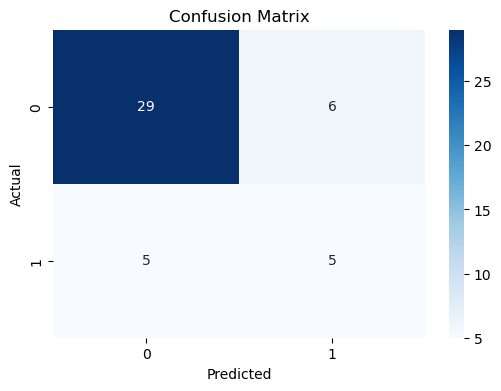

INFO: Injury risk model for L_ANKLE - Evaluation Metrics: {'Accuracy': 0.7555555555555555, 'Precision': 0.45454545454545453, 'Recall': 0.5, 'F1-Score': 0.47619047619047616, 'ROC-AUC': 0.6171428571428571}
INFO: All required columns are present.
INFO: Performed train-test split: train (198, 250), test (50, 250)
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.78, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.9976689976689976}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 1.0, 'Recall': 0.18181818181818182, 'F1-Score': 0.3076923076923077, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.78, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: All required columns are present.
INFO: Prepared injury data for R_ANKLE: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['R_ANKLE_avg_power', 'R_ANKLE_avg_power_diff', 'R_ANKLE_avg_power_ma_3', 'R_ANKLE_avg_power_ma_5'], Target: R_ANKLE_injury_risk
INFO: All required c

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6621 - loss: 0.6788 - val_accuracy: 0.3556 - val_loss: 0.7125
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5876 - loss: 0.7170 - val_accuracy: 0.3556 - val_loss: 0.7148
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5947 - loss: 0.6798 - val_accuracy: 0.3556 - val_loss: 0.7081
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6591 - loss: 0.6652 - val_accuracy: 0.5111 - val_loss: 0.6918
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6882 - loss: 0.7231 - val_accuracy: 0.4222 - val_loss: 0.6945
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6423 - loss: 0.7055 - val_accuracy: 0.4444 - val_loss: 0.6911
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7069 - loss: 0.6843 - val_accuracy: 0.4000 - val_loss: 0.6951
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6601 - loss: 0.6494 - val_accuracy: 0.4222 - val_loss:

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


INFO: Classification Evaluation - Accuracy: 0.7111111111111111, Precision: 0.2727272727272727, Recall: 0.375, F1: 0.3157894736842105, ROC-AUC: 0.652027027027027


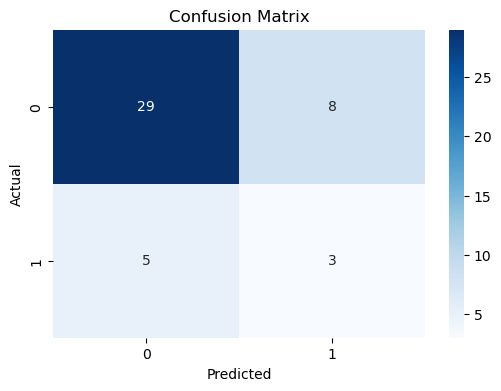

INFO: Injury risk model for R_ANKLE - Evaluation Metrics: {'Accuracy': 0.7111111111111111, 'Precision': 0.2727272727272727, 'Recall': 0.375, 'F1-Score': 0.3157894736842105, 'ROC-AUC': 0.652027027027027}
INFO: All required columns are present.
INFO: Performed train-test split: train (198, 250), test (50, 250)
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: All required columns are present.
INFO: Prepared injury data for L_KNEE: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['L_KNEE_avg_power', 'L_KNEE_avg_power_diff', 'L_KNEE_avg_power_ma_3', 'L_KNEE_avg_power_ma_5'], Target: L_KNEE_injury_risk
INFO: All required columns are present.
INFO: Performed train-test split:

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.5474 - loss: 0.7024 - val_accuracy: 0.4667 - val_loss: 0.6902
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5781 - loss: 0.7136 - val_accuracy: 0.7333 - val_loss: 0.6729
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7126 - loss: 0.6709 - val_accuracy: 0.7333 - val_loss: 0.6512
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7707 - loss: 0.7174 - val_accuracy: 0.7333 - val_loss: 0.6368
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7771 - loss: 0.7038 - val_accuracy: 0.8000 - val_loss: 0.6295
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8054 - loss: 0.6618 - val_accuracy: 0.8000 - val_loss: 0.6144
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7893 - loss: 0.6917 - val_accuracy: 0.7556 - val_loss: 0.6006
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7473 - loss: 0.7154 - val_accuracy: 0.7556 - val_loss:

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


INFO: Classification Evaluation - Accuracy: 0.7333333333333333, Precision: 0.38461538461538464, Recall: 0.5555555555555556, F1: 0.45454545454545453, ROC-AUC: 0.7191358024691359


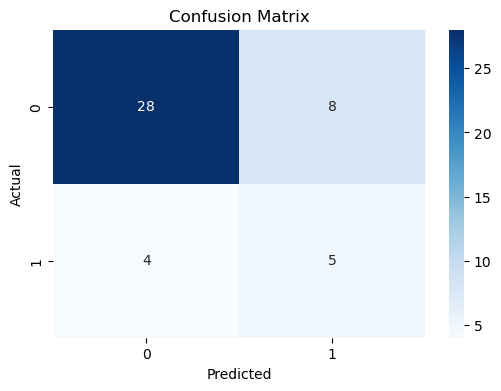

INFO: Injury risk model for L_KNEE - Evaluation Metrics: {'Accuracy': 0.7333333333333333, 'Precision': 0.38461538461538464, 'Recall': 0.5555555555555556, 'F1-Score': 0.45454545454545453, 'ROC-AUC': 0.7191358024691359}
INFO: All required columns are present.
INFO: Performed train-test split: train (198, 250), test (50, 250)
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: All required columns are present.
INFO: Prepared injury data for R_KNEE: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['R_KNEE_avg_power', 'R_KNEE_avg_power_diff', 'R_KNEE_avg_power_ma_3', 'R_KNEE_avg_power_ma_5'], Target: R_KNEE_injury_risk
INFO: All required columns are present.
INFO: Performed tr

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6630 - loss: 0.6575 - val_accuracy: 0.4444 - val_loss: 0.6848
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5696 - loss: 0.6576 - val_accuracy: 0.4444 - val_loss: 0.6920
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5786 - loss: 0.6798 - val_accuracy: 0.4444 - val_loss: 0.7234
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5605 - loss: 0.6576 - val_accuracy: 0.4444 - val_loss: 0.7297
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5920 - loss: 0.6990 - val_accuracy: 0.4222 - val_loss: 0.7355
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5049 - loss: 0.6833 - val_accuracy: 0.4000 - val_loss: 0.7324
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5194 - loss: 0.6886 - val_accuracy: 0.4000 - val_loss: 0.7257
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5464 - loss: 0.6452 - val_accuracy: 0.4667 - val_loss: 0.

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


INFO: Classification Evaluation - Accuracy: 0.6666666666666666, Precision: 0.18181818181818182, Recall: 0.25, F1: 0.21052631578947367, ROC-AUC: 0.6655405405405406


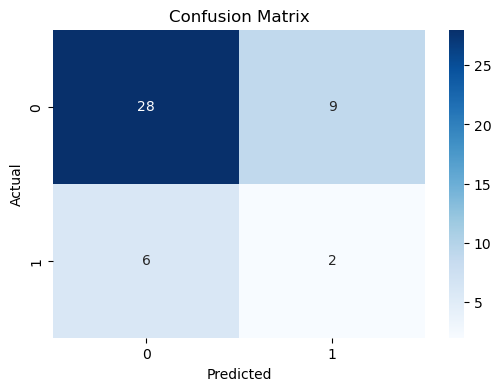

INFO: Injury risk model for R_KNEE - Evaluation Metrics: {'Accuracy': 0.6666666666666666, 'Precision': 0.18181818181818182, 'Recall': 0.25, 'F1-Score': 0.21052631578947367, 'ROC-AUC': 0.6655405405405406}
INFO: All required columns are present.
INFO: Performed train-test split: train (198, 250), test (50, 250)
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.940379403794038}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.86, 'Precision': 1.0, 'Recall': 0.2222222222222222, 'F1-Score': 0.36363636363636365, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.94579945799458}
INFO: All required columns are present.
INFO: Prepared injury data for L_HIP: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['L_HIP_avg_power', 'L_HIP_avg_power_diff', 'L_HIP_avg_power_ma_3', 'L_HIP_avg_power_ma_5'], Target: L_HIP_injury_risk
INFO: All required c

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7712 - loss: 0.6937 - val_accuracy: 0.6889 - val_loss: 0.6832
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7854 - loss: 0.6558 - val_accuracy: 0.7556 - val_loss: 0.6623
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7810 - loss: 0.6823 - val_accuracy: 0.7778 - val_loss: 0.6532
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7787 - loss: 0.6885 - val_accuracy: 0.7111 - val_loss: 0.6541
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7775 - loss: 0.6661 - val_accuracy: 0.7333 - val_loss: 0.6580
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7118 - loss: 0.6838 - val_accuracy: 0.6000 - val_loss: 0.6614
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6455 - loss: 0.7131 - val_accuracy: 0.5778 - val_loss: 0.6500
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5906 - loss: 0.6859 - val_accuracy: 0.6000 - val_loss:

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


INFO: Classification Evaluation - Accuracy: 0.6, Precision: 0.2631578947368421, Recall: 0.5555555555555556, F1: 0.35714285714285715, ROC-AUC: 0.6080246913580247


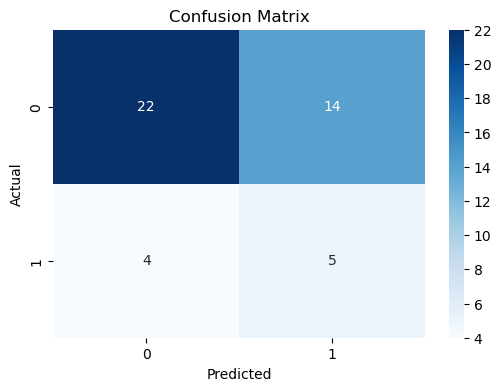

INFO: Injury risk model for L_HIP - Evaluation Metrics: {'Accuracy': 0.6, 'Precision': 0.2631578947368421, 'Recall': 0.5555555555555556, 'F1-Score': 0.35714285714285715, 'ROC-AUC': 0.6080246913580247}
INFO: All required columns are present.
INFO: Performed train-test split: train (198, 250), test (50, 250)
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.8, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 1.0, 'Recall': 0.1, 'F1-Score': 0.18181818181818182, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.8, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.995}
INFO: All required columns are present.
INFO: Prepared injury data for R_HIP: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['R_HIP_avg_power', 'R_HIP_avg_power_diff', 'R_HIP_avg_power_ma_3', 'R_HIP_avg_power_ma_5'], Target: R_HIP_injury_risk
INFO: All required columns are present.
INFO: Performed train-tes

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6449 - loss: 0.6644 - val_accuracy: 0.6444 - val_loss: 0.6675
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7074 - loss: 0.7055 - val_accuracy: 0.7111 - val_loss: 0.6582
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7330 - loss: 0.6732 - val_accuracy: 0.7111 - val_loss: 0.6512
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6922 - loss: 0.7326 - val_accuracy: 0.6444 - val_loss: 0.6586
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7080 - loss: 0.6829 - val_accuracy: 0.5556 - val_loss: 0.6694
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6364 - loss: 0.6558 - val_accuracy: 0.5778 - val_loss: 0.6723
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6449 - loss: 0.6373 - val_accuracy: 0.5333 - val_loss: 0.6817
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5605 - loss: 0.6722 - val_accuracy: 0.4889 - val_loss:

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


INFO: Classification Evaluation - Accuracy: 0.7111111111111111, Precision: 0.4166666666666667, Recall: 0.45454545454545453, F1: 0.43478260869565216, ROC-AUC: 0.56951871657754


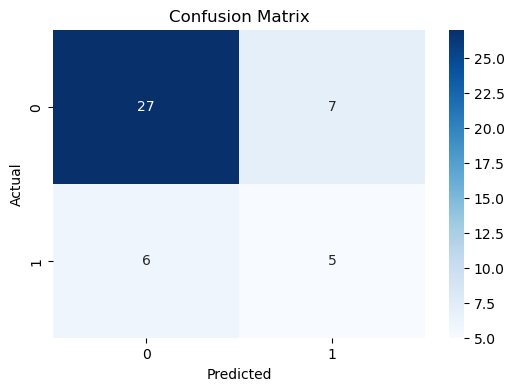

INFO: Injury risk model for R_HIP - Evaluation Metrics: {'Accuracy': 0.7111111111111111, 'Precision': 0.4166666666666667, 'Recall': 0.45454545454545453, 'F1-Score': 0.43478260869565216, 'ROC-AUC': 0.56951871657754}
INFO: All required columns are present.
INFO: Performed train-test split: train (198, 250), test (50, 250)
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.76, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.76, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.76, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: All required columns are present.
INFO: Prepared injury data for L_ELBOW: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['L_ELBOW_avg_power', 'L_ELBOW_avg_power_diff', 'L_ELBOW_avg_power_ma_3', 'L_ELBOW_avg_power_ma_5'], Target: L_ELBOW_injury_risk
INFO: All required columns are present.
INFO: Performed

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6016 - loss: 0.6811 - val_accuracy: 0.7333 - val_loss: 0.6767
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7397 - loss: 0.6852 - val_accuracy: 0.7333 - val_loss: 0.6462
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7322 - loss: 0.6872 - val_accuracy: 0.7111 - val_loss: 0.6394
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6914 - loss: 0.6426 - val_accuracy: 0.7333 - val_loss: 0.6419
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6385 - loss: 0.6788 - val_accuracy: 0.7111 - val_loss: 0.6477
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6501 - loss: 0.6203 - val_accuracy: 0.6222 - val_loss: 0.6555
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6473 - loss: 0.6833 - val_accuracy: 0.4667 - val_loss: 0.7093
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6560 - loss: 0.6088 - val_accuracy: 0.4667 - val_loss:

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


INFO: Classification Evaluation - Accuracy: 0.7111111111111111, Precision: 0.14285714285714285, Recall: 0.125, F1: 0.13333333333333333, ROC-AUC: 0.5236486486486486


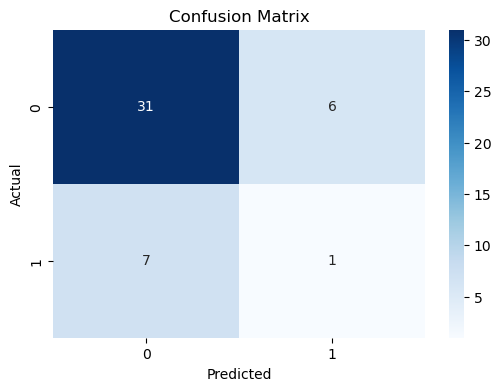

INFO: Injury risk model for L_ELBOW - Evaluation Metrics: {'Accuracy': 0.7111111111111111, 'Precision': 0.14285714285714285, 'Recall': 0.125, 'F1-Score': 0.13333333333333333, 'ROC-AUC': 0.5236486486486486}
INFO: All required columns are present.
INFO: Performed train-test split: train (198, 250), test (50, 250)
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: All required columns are present.
INFO: Prepared injury data for R_ELBOW: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['R_ELBOW_avg_power', 'R_ELBOW_avg_power_diff', 'R_ELBOW_avg_power_ma_3', 'R_ELBOW_avg_power_ma_5'], Target: R_ELBOW_injury_risk
INFO: All required columns are present.
INFO: Performed train-te

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4877 - loss: 0.6842 - val_accuracy: 0.2889 - val_loss: 0.7130
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5261 - loss: 0.6455 - val_accuracy: 0.3111 - val_loss: 0.7147
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5156 - loss: 0.6912 - val_accuracy: 0.4889 - val_loss: 0.7045
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5535 - loss: 0.6529 - val_accuracy: 0.5778 - val_loss: 0.6723
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5985 - loss: 0.6310 - val_accuracy: 0.5556 - val_loss: 0.6613
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5799 - loss: 0.6535 - val_accuracy: 0.5111 - val_loss: 0.6844
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5493 - loss: 0.6708 - val_accuracy: 0.4667 - val_loss: 0.7141
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6093 - loss: 0.6768 - val_accuracy: 0.4222 - val_loss:

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


INFO: Classification Evaluation - Accuracy: 0.5555555555555556, Precision: 0.06666666666666667, Recall: 0.14285714285714285, F1: 0.09090909090909091, ROC-AUC: 0.4887218045112782


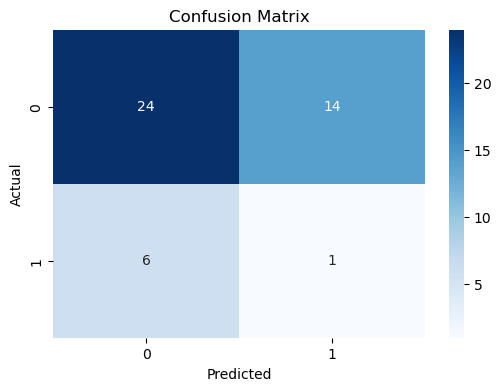

INFO: Injury risk model for R_ELBOW - Evaluation Metrics: {'Accuracy': 0.5555555555555556, 'Precision': 0.06666666666666667, 'Recall': 0.14285714285714285, 'F1-Score': 0.09090909090909091, 'ROC-AUC': 0.4887218045112782}
INFO: All required columns are present.
INFO: Performed train-test split: train (198, 250), test (50, 250)
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.84, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.84, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.84, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: All required columns are present.
INFO: Prepared injury data for L_WRIST: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['L_WRIST_avg_power', 'L_WRIST_avg_power_diff', 'L_WRIST_avg_power_ma_3', 'L_WRIST_avg_power_ma_5'], Target: L_WRIST_injury_risk
INFO: All required columns are present.
INFO: Perf

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.2267 - loss: 0.6805 - val_accuracy: 0.5778 - val_loss: 0.6889
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4576 - loss: 0.7100 - val_accuracy: 0.6889 - val_loss: 0.6818
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6340 - loss: 0.6932 - val_accuracy: 0.7111 - val_loss: 0.6770
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6807 - loss: 0.6702 - val_accuracy: 0.6889 - val_loss: 0.6712
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6860 - loss: 0.6825 - val_accuracy: 0.6444 - val_loss: 0.6733
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6906 - loss: 0.6661 - val_accuracy: 0.6667 - val_loss: 0.6630
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6503 - loss: 0.6658 - val_accuracy: 0.6222 - val_loss: 0.6622
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5796 - loss: 0.6711 - val_accuracy: 0.5556 - val_loss:

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


INFO: Classification Evaluation - Accuracy: 0.8, Precision: 0.4, Recall: 0.25, F1: 0.3076923076923077, ROC-AUC: 0.4797297297297297


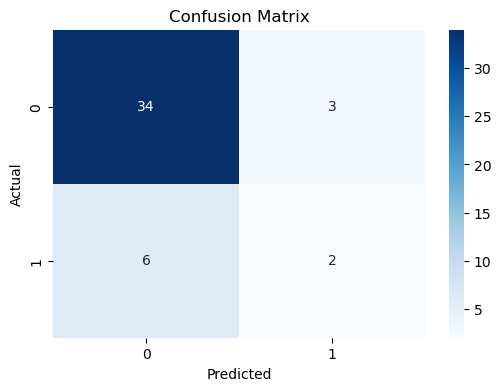

INFO: Injury risk model for L_WRIST - Evaluation Metrics: {'Accuracy': 0.8, 'Precision': 0.4, 'Recall': 0.25, 'F1-Score': 0.3076923076923077, 'ROC-AUC': 0.4797297297297297}
INFO: All required columns are present.
INFO: Performed train-test split: train (198, 250), test (50, 250)
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.9999999999999999}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.82, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: All required columns are present.
INFO: Prepared injury data for R_WRIST: X shape=(248, 4), y shape=(248,)
INFO: Features used: ['R_WRIST_avg_power', 'R_WRIST_avg_power_diff', 'R_WRIST_avg_power_ma_3', 'R_WRIST_avg_power_ma_5'], Target: R_WRIST_injury_risk
INFO: All required columns are present.
INFO: Performed train-test split: train (1

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5752 - loss: 0.6846 - val_accuracy: 0.6222 - val_loss: 0.6864
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6032 - loss: 0.7501 - val_accuracy: 0.6000 - val_loss: 0.6826
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6895 - loss: 0.7232 - val_accuracy: 0.5778 - val_loss: 0.6737
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6907 - loss: 0.6660 - val_accuracy: 0.6222 - val_loss: 0.6679
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7646 - loss: 0.6433 - val_accuracy: 0.6222 - val_loss: 0.6597
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7811 - loss: 0.6824 - val_accuracy: 0.6222 - val_loss: 0.6592
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7903 - loss: 0.5985 - val_accuracy: 0.6222 - val_loss: 0.6497
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7484 - loss: 0.6366 - val_accuracy: 0.6444 - val_loss: 0.

INFO: Trained model for up to 100 epochs with batch size 32.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


INFO: Classification Evaluation - Accuracy: 0.6444444444444445, Precision: 0.25, Recall: 0.3, F1: 0.2727272727272727, ROC-AUC: 0.5371428571428571


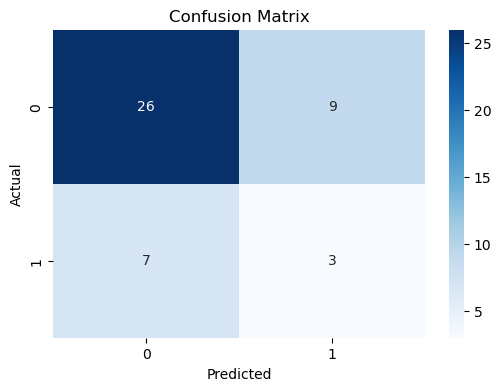

INFO: Injury risk model for R_WRIST - Evaluation Metrics: {'Accuracy': 0.6444444444444445, 'Precision': 0.25, 'Recall': 0.3, 'F1-Score': 0.2727272727272727, 'ROC-AUC': 0.5371428571428571}
INFO: All required columns are present.
INFO: Performed train-test split: train (198, 250), test (50, 250)
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.78, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.78, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 1.0}
INFO: Baseline Evaluation Metrics: {'Accuracy': 0.78, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.9999999999999999}
INFO: Baseline model results:
INFO: L_ANKLE: {'LogisticRegression': {'Accuracy': 0.78, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0, 'ROC-AUC': 0.9976689976689976}, 'RandomForest': {'Accuracy': 0.82, 'Precision': 1.0, 'Recall': 0.18181818181818182, 'F1-Score': 0.3076923076923077, 'ROC-AUC': 1.0}, 'SVM': {'Accuracy': 0.78, 'P

         Deep_Accuracy  Deep_Precision  Deep_Recall  Deep_F1-Score  \
Joint                                                                
L_ANKLE       0.755556        0.454545     0.500000       0.476190   
R_ANKLE       0.711111        0.272727     0.375000       0.315789   
L_KNEE        0.733333        0.384615     0.555556       0.454545   
R_KNEE        0.666667        0.181818     0.250000       0.210526   
L_HIP         0.600000        0.263158     0.555556       0.357143   
R_HIP         0.711111        0.416667     0.454545       0.434783   
L_ELBOW       0.711111        0.142857     0.125000       0.133333   
R_ELBOW       0.555556        0.066667     0.142857       0.090909   
L_WRIST       0.800000        0.400000     0.250000       0.307692   
R_WRIST       0.644444        0.250000     0.300000       0.272727   

         Deep_ROC-AUC  LogisticRegression_Accuracy  \
Joint                                                
L_ANKLE      0.617143                         0.78 

INFO: Joint: L_ANKLE, Evaluation: {'Accuracy': 0.7555555555555555, 'Precision': 0.45454545454545453, 'Recall': 0.5, 'F1-Score': 0.47619047619047616, 'ROC-AUC': 0.6171428571428571}
INFO: Joint: R_ANKLE, Evaluation: {'Accuracy': 0.7111111111111111, 'Precision': 0.2727272727272727, 'Recall': 0.375, 'F1-Score': 0.3157894736842105, 'ROC-AUC': 0.652027027027027}
INFO: Joint: L_KNEE, Evaluation: {'Accuracy': 0.7333333333333333, 'Precision': 0.38461538461538464, 'Recall': 0.5555555555555556, 'F1-Score': 0.45454545454545453, 'ROC-AUC': 0.7191358024691359}
INFO: Joint: R_KNEE, Evaluation: {'Accuracy': 0.6666666666666666, 'Precision': 0.18181818181818182, 'Recall': 0.25, 'F1-Score': 0.21052631578947367, 'ROC-AUC': 0.6655405405405406}
INFO: Joint: L_HIP, Evaluation: {'Accuracy': 0.6, 'Precision': 0.2631578947368421, 'Recall': 0.5555555555555556, 'F1-Score': 0.35714285714285715, 'ROC-AUC': 0.6080246913580247}
INFO: Joint: R_HIP, Evaluation: {'Accuracy': 0.7111111111111111, 'Precision': 0.4166666666

In [ ]:
# classification_module.py
import logging
import sys
# from common import (
#     load_final_ml_dataset, prepare_joint_features, feature_engineering,
#     add_fake_body_metrics, simulate_workouts, validate_temporal_consistency,
#     add_injury_risk_labels_per_joint, prepare_injury_data, prepare_dataset_for_training,
#     build_enhanced_lstm, train_model, evaluate_model_classification, compute_class_weights, custom_dynamic_threshold
# )
# from baseline_models import run_logistic_regression, run_random_forest, run_svm

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def build_classification_lstm(input_shape, bidirectional=False):
    """
    Builds an LSTM model for classification tasks.
    """
    return build_enhanced_lstm(input_shape, target_type='classification', bidirectional=bidirectional)

def train_classification_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, class_weight=None):
    """
    Trains the classification model with early stopping.
    """
    return train_model(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)

def run_baseline_models(df, joint, timesteps=5, test_size=0.2, debug=True):
    """
    Prepares data for the given joint and runs baseline classifiers.
    Returns a dictionary of baseline model metrics.
    """
    # For baseline models, we do not need to form sequences.
    # Use the same feature names as in the deep learning pipeline.
    feature_names = [f"{joint}_avg_power", f"{joint}_avg_power_diff", f"{joint}_avg_power_ma_3", f"{joint}_avg_power_ma_5"]
    target_col = f"{joint}_injury_risk"
    
    # Ensure required columns exist.
    if not check_required_columns(df, feature_names + [target_col]):
        logging.error(f"Missing required columns for joint {joint} baseline evaluation.")
        sys.exit(1)
    
    # Perform a temporal train-test split (without sequencing)
    sort_col = 'shot_id' if 'shot_id' in df.columns else 'trial_id'
    df_sorted = df.sort_values(sort_col).reset_index(drop=True)
    train_df, test_df = temporal_train_test_split(df_sorted, test_size=test_size)
    
    X_train = train_df[feature_names].values
    y_train = train_df[target_col].values
    X_test = test_df[feature_names].values
    y_test = test_df[target_col].values
    
    # Run the baseline models
    lr_model, lr_metrics = run_logistic_regression(X_train, y_train, X_test, y_test)
    rf_model, rf_metrics = run_random_forest(X_train, y_train, X_test, y_test)
    svm_model, svm_metrics = run_svm(X_train, y_train, X_test, y_test)
    
    return {'LogisticRegression': lr_metrics,
            'RandomForest': rf_metrics,
            'SVM': svm_metrics}

# Then, modify your classification_pipeline to also run baseline models:
def classification_pipeline(data_filepath, test_size=0.2, timesteps=5, debug=True):
    """
    The full classification pipeline.
    """
    joint_prefixes = ["L_ANKLE", "R_ANKLE", "L_KNEE", "R_KNEE", "L_HIP", "R_HIP", "L_ELBOW", "R_ELBOW", "L_WRIST", "R_WRIST"]

    df = load_final_ml_dataset(data_filepath, debug=debug)
    df = prepare_joint_features(df, debug=debug)
    df = feature_engineering(df, debug=debug)
    df = add_fake_body_metrics(df, debug=debug)
    df = simulate_workouts(df, debug=debug)
    if not validate_temporal_consistency(df, debug=debug):
        logging.error("Temporal consistency validation failed. Exiting.")
        sys.exit(1)
    # Compute differentials for joint avg_power features
    diff_columns = [f"{joint}_avg_power" for joint in joint_prefixes if f"{joint}_avg_power" in df.columns]
    diff_df = compute_trial_differentials(df, diff_columns, debug=debug)
    df = merge_differentials(df, diff_df, debug=debug)
    df = add_moving_average_features(df, features=diff_columns, windows=[3, 5], debug=debug)
    # Add injury risk labels.
    df = add_injury_risk_labels_per_joint(df, joint_prefixes, risk_feature_suffix='_avg_power_diff',
                                            dynamic_threshold_func=custom_dynamic_threshold, debug=debug)
    joint_injury_models = {}
    baseline_results = {}
    # Loop through each joint.
    for joint in joint_prefixes:
        target_col = f"{joint}_injury_risk"
        if target_col not in df.columns:
            logging.warning(f"Skipping {joint}: '{target_col}' missing.")
            continue
        # Run deep learning model as before
        X_joint, y_joint, shot_ids = prepare_injury_data(df, joint, risk_feature_suffix='_avg_power_diff', debug=debug)
        feature_names = [f"{joint}_avg_power", f"{joint}_avg_power_diff", f"{joint}_avg_power_ma_3", f"{joint}_avg_power_ma_5"]
        X_train_seq, y_train_seq, X_test_seq, y_test_seq, scaler = prepare_dataset_for_training(
            df, feature_names, target_col, timesteps, test_size=test_size)
        class_weight = compute_class_weights(y_train_seq)
        input_shape = (timesteps, X_train_seq.shape[-1])
        model = build_classification_lstm(input_shape, bidirectional=False)
        history = train_classification_model(model, X_train_seq, y_train_seq, X_test_seq, y_test_seq,
                                             epochs=100, batch_size=32, class_weight=class_weight)
        y_pred = model.predict(X_test_seq)
        metrics = evaluate_model_classification(y_test_seq, y_pred, threshold=0.5)
        logging.info(f"Injury risk model for {joint} - Evaluation Metrics: {metrics}")
        joint_injury_models[joint] = {
            'model': model,
            'history': history,
            'evaluation': metrics
        }
        # Also run baseline models for this joint
        baseline_results[joint] = run_baseline_models(df, joint, timesteps=timesteps, test_size=test_size, debug=debug)
    # Optionally, you could combine deep model and baseline results in a dashboard.
    logging.info("Baseline model results:")
    for joint, results in baseline_results.items():
        logging.info(f"{joint}: {results}")
    return joint_injury_models, baseline_results


def create_results_table(deep_results, baseline_results):
    """
    Combine deep model and baseline model results into one DataFrame.
    
    deep_results: dict of deep model evaluation metrics per joint.
    baseline_results: dict of baseline results (each is itself a dict with keys for model names).
    """
    rows = []
    for joint in deep_results.keys():
        row = {'Joint': joint}
        # Add deep model metrics with a prefix, e.g., "Deep_"
        for metric, value in deep_results[joint]['evaluation'].items():
            row[f"Deep_{metric}"] = value
        # For baseline models, iterate over each baseline model's metrics:
        if joint in baseline_results:
            for baseline_model, metrics in baseline_results[joint].items():
                for metric, value in metrics.items():
                    # Example column name: "LR_Accuracy", "RF_Recall", "SVM_F1-Score"
                    row[f"{baseline_model}_{metric}"] = value
        rows.append(row)
    results_df = pd.DataFrame(rows)
    results_df.set_index('Joint', inplace=True)
    return results_df


if __name__ == "__main__":
    data_filepath = "../../data/processed/final_ml_dataset.csv"
    joint_models, baseline_results = classification_pipeline(data_filepath, debug=True)
    results_table = create_results_table(joint_models, baseline_results)
    print(results_table)
    for joint, model_info in joint_models.items():
        logging.info(f"Joint: {joint}, Evaluation: {model_info['evaluation']}")
    # Optionally, log baseline results:
    for joint, results in baseline_results.items():
        logging.info(f"Baseline results for {joint}: {results}")

